# !TODO  
- [x] handle time consuming cells
- [x] check train set's balansing
- [x] compare to dummyClassifier  
- [x] move functions to .py files
    - [x] check file ml_metrics_train
    - [x] check file key_results
- [x] simplify parameters of transformer calsses inhereted to find out with inhering. test using GridSearchCV.fit
- [ ] try to enchanse the model
- [ ] check markdown cells and comments with !


# Import

In [1]:
import math
import os, sys
from icecream import ic
from typing import Iterable
from IPython.display import  Markdown, display
import re

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multi adding  
    sys.path.append("../scripts/")
     
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from helpers import load_or_run
from input_output_plot.plotting import get_fig_and_axes
from input_output_plot.printing import output_formatting as paint
from input_output_plot.printing import display_df_side_by_side
from consts import format, color, del_format, results_dir, pkl_dir

# Load data sets

In [2]:
#X_train_file_small = os.path.join(pkl_dir, 'x_train_features_small.pkl')
X_train_file = os.path.join(pkl_dir, 'x_train_features.pkl')
X_train_addition_file = os.path.join(pkl_dir, 'x_train_addition_features.pkl')
y_train_file = os.path.join(pkl_dir, 'y_train_features.pkl')
X_train_return_file = os.path.join(pkl_dir, 'x_train_return_features.pkl')
x_train_capped_features_file = os.path.join(pkl_dir, 'x_train_capped_features.pkl')
X_test_file = os.path.join(pkl_dir, 'x_test_features.pkl')
X_test_addition_file = os.path.join(pkl_dir, 'x_test_addition_features.pkl')
y_test_file = os.path.join(pkl_dir, 'y_test_features.pkl')
X_test_return_file = os.path.join(pkl_dir, 'x_test_return_features.pkl')

sp500_history_file = os.path.join(pkl_dir, 'sp500_history.pkl')

In [3]:
print(f'Load previously saved data from {pkl_dir}')
with open(X_train_file, 'rb') as fx, open(X_train_addition_file, 'rb') as fxa, open(y_train_file, 'rb') as fy, open(X_train_return_file, 'rb') as fxt, open(x_train_capped_features_file, 'rb') as fxc:
    X_train = pickle.load(fx)
    X_train_addition = pickle.load(fxa)
    y_train = pickle.load(fy)
    X_train_return = pickle.load(fxt)
    X_train_capped = pickle.load(fxc)

with open(X_test_file, 'rb') as fx, open(X_test_addition_file, 'rb') as fxa, open(y_test_file, 'rb') as fy, open(X_test_return_file, 'rb') as fxt:
    X_test = pickle.load(fx)
    X_test_addition = pickle.load(fxa)
    y_test = pickle.load(fy)
    X_test_return = pickle.load(fxt)

with open(sp500_history_file, 'rb') as f:
    sp500_history = pickle.load(f)

Load previously saved data from ../results/pickled


# Cross validation

In [4]:
from input_output_plot.plotting import plot_cv
from model.model_selection import MultiTimeSeriesSplit, is_train_test_folds_have_common_dates

## Determine folds sizes

The task's requirement for cross-validation is "the train set has to be bigger than 2 years history". Let determine the number of days in the first 2 years of the train set.

In [5]:
statistic = {}
statistic['n_companies_train'] = len(X_train['Name'].unique())
statistic['n_companies_test'] = len(X_test['Name'].unique())
print(f'Number of companies in the train set: {paint(statistic['n_companies_train'], format)}')
print(f'Number of companies in the test set: {paint(statistic['n_companies_test'], format)}')

Number of companies in the train set: 498
Number of companies in the test set: 505


In [6]:
X_train_dates= X_train.index.unique()
statistic['X_train_dates'] = len(X_train_dates)
print(f'Days in the the train set: {paint(statistic['X_train_dates'], format)}')
days_in_2years_history = len(X_train_dates[(X_train_dates>=X_train_dates.min()) & (X_train_dates<X_train_dates.min()+pd.DateOffset(years=2))])
statistic['days_in_2years_history'] = days_in_2years_history
print(f'Days in the first 2 years of the train set: {paint(statistic['days_in_2years_history'] , format)}')
statistic['X_test_dates'] = len(X_test.index.get_level_values('date').unique())
print(f'Days in the test set: {paint(statistic['X_test_dates'], format)}')

Days in the the train set: 955
Days in the first 2 years of the train set: 504
Days in the test set: 275


Let's take `validation_set_size`=25 and `n_splits`=11. It will cover the whole X_test: 11*25=275 

In [7]:
validation_set_size=25
n_splits=11

In [8]:
# determine the maximum length of the train fold in the first split which let validation folds cover the given test set 
max_train_size = statistic['X_train_dates'] - statistic['X_test_dates']
statistic['max_train_size'] = max_train_size
print(f'Maximum size of the train fold in the first split: {paint(max_train_size, format)}')

Maximum size of the train fold in the first split: 680


## TimeSeries Split

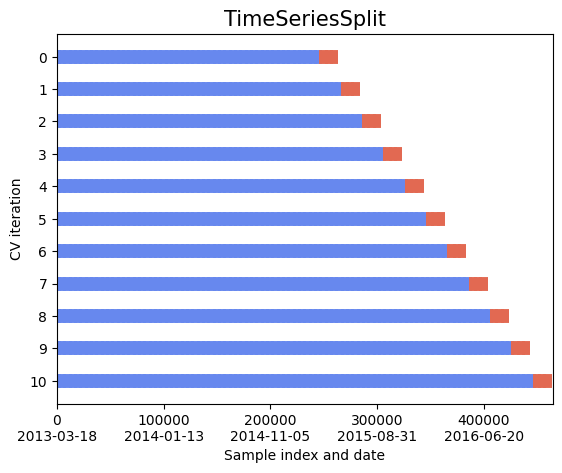

In [9]:
# create a cross-validation object with minimal train set equal 2 years of stock's history + 10 days of stock's history
tscv = MultiTimeSeriesSplit(n_splits=n_splits, 
                            min_train_size=days_in_2years_history+10, 
                            max_train_size=None, 
                            #test_size=validation_set_size, 
                            gap=0)
fig = plot_cv(tscv, 'TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

This time series split is built with minimum length of train fold according with task requipment (2 years history). Let's get some statistic on it:

In [10]:
statistic['max_days_in_validation_set'] = tscv.get_test_size()
print(f'Length of test (number of days) set in the cross validation showed above: {paint(statistic['max_days_in_validation_set'], format)}')

Length of test (number of days) set in the cross validation showed above: 40


In [11]:
time_series_split_min_train_set = len(X_train)
for train_idxs, _ in tscv.split(X_train):
    time_series_split_min_train_set = min(len(X_train.iloc[train_idxs]), time_series_split_min_train_set)
statistic['samples_in_min_train_set'] = time_series_split_min_train_set
print(f'Length of minimum train fold: {paint(statistic['samples_in_min_train_set'], format)}')

Length of minimum train fold: 248898


Create a cross-validation object with chosen test's length (`25`). Train set is requered to be bigger than `2 years` of stock's history + 10 days of stock's history

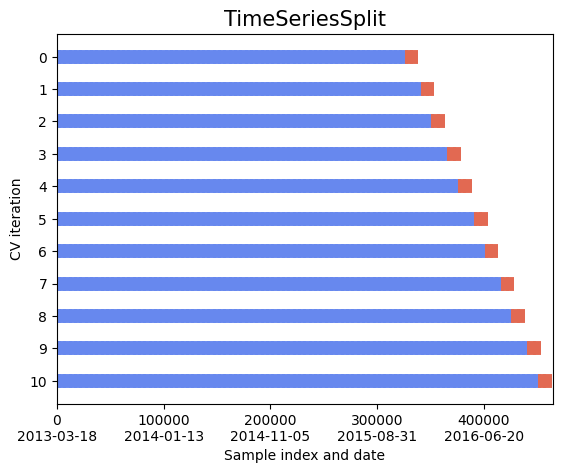

In [12]:
tscv_25 = MultiTimeSeriesSplit(n_splits=n_splits, 
                            min_train_size=days_in_2years_history+10, 
                            max_train_size=None, 
                            test_size=validation_set_size, 
                            gap=0)
fig = plot_cv(tscv_25, 'TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

In [13]:
print(f'Length of test (number of days) set in the cross validation showed above: {paint(tscv_25.get_test_size(), format)}')
print(f'Minimum length of the train sets (number of days) in the cross-validation above: {paint(tscv_25.get_min_train_size(), format)}')

Length of test (number of days) set in the cross validation showed above: 25
Minimum length of the train sets (number of days) in the cross-validation above: 514


This time the time series split has a train fold with maximum length for the chosen test size.

In [14]:
time_series_split_max_train_set = 0
for train_idxs, _ in tscv_25.split(X_train):
    time_series_split_max_train_set = max(len(X_train.iloc[train_idxs]), time_series_split_max_train_set)
statistic['samples_in_min_train_set'] = time_series_split_max_train_set
print(f'Length of maximum train fold: {paint(statistic['samples_in_min_train_set'], format)}')

Length of maximum train fold: 453962


In [15]:
print(f'Are there data from the same day in the train and test folds : {paint(is_train_test_folds_have_common_dates(tscv, X_train), format)}')

Are there data from the same day in the train and test folds : False


## Blocking TimeSeries Split

In [16]:
tscv_blocking = MultiTimeSeriesSplit(n_splits=n_splits, 
                                     max_train_size=max_train_size, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size, 
                                     gap=0)

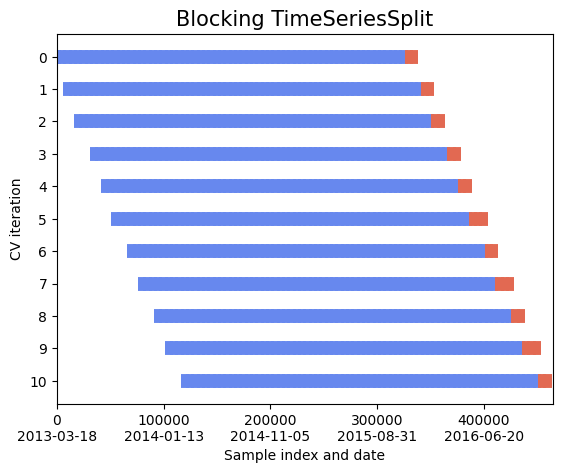

In [17]:
fig = plot_cv(tscv_blocking, 'Blocking TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

In [18]:
print(f'Minimum length of the train sets {paint('(number of days)',format)} in the cross-validation above: {paint(tscv_blocking.get_min_train_size(), format)}')
print(f'Length of train folds:')
i = 0
end=' -> '
for train_idxs, _ in tscv_blocking.split(X_train):
    if i == n_splits-1:
        end = '\n'
    print(f'{i}: {len(X_train.iloc[train_idxs])}, {len(X_train.iloc[train_idxs]['Name'].unique())}', end=end)
    i += 1

Minimum length of the train sets (number of days) in the cross-validation above: 504
Length of train folds:
0: 329822, 494 -> 1: 330279, 495 -> 2: 330758, 495 -> 3: 331245, 496 -> 4: 331667, 496 -> 5: 332036, 497 -> 6: 332411, 497 -> 7: 332786, 497 -> 8: 333182, 498 -> 9: 333557, 498 -> 10: 333932, 498


In [19]:
print(f'Do the train and test folds contain data from the same day: {paint(is_train_test_folds_have_common_dates(tscv_blocking, X_train), format)}')

Do the train and test folds contain data from the same day: False


In [20]:
print('Statistic:')
print(pd.Series(statistic))

Statistic:
n_companies_train                498
n_companies_test                 505
X_train_dates                    955
days_in_2years_history           504
X_test_dates                     275
max_train_size                   680
max_days_in_validation_set        40
samples_in_min_train_set      453962
dtype: int64


# Model selecting

In [ ]:
import warnings

from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler, MaxAbsScaler, PowerTransformer, KBinsDiscretizer, QuantileTransformer, OrdinalEncoder
from sklearn.decomposition import FastICA, PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, f1_score, log_loss, confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.model_selection import TunedThresholdClassifierCV

import seaborn as sns

from model.analyzing import KEY_BEST_ESTIMATOR_SCORES, concatenate_estimators_scores
from model.analyzing import add_scores_of_stage_to_file, add_grid_search_key_results, create_tables_of_scores_by_param, print_scores_by_param, plot_validation_by, create_train_test_comparation_tables
from model.model_selection import train_classifiers, EncoderNameScalerDigitCols, NamedTransformer
from model.validating import cv_scores_on_splits, cv_scores, create_comparation_table, cv_scores_on_splits_by_param, cv_scores_on_splits_per_param
from model.validating import compare_scores_on_splits, predictions_on_splits
from input_output_plot.plotting import lineplot, barplot, plot_features_count, plot_validation_curves
from input_output_plot.printing import add_data_frames_to_file

## Components

### Scorer

Define metrics to evaluate the performance of the cross-validated model.

In [22]:
scores = ['accuracy', 'average_precision', 'f1', 'roc_auc', 'log_loss']
confusion_matrix_cells = ['tn', 'fp', 'fn', 'tp']
def scorer(clf, X, y):
    scores = {
            'accuracy': np.nan,
            'average_precision': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'log_loss': np.nan,
            'tn': np.nan, 'fp': np.nan,
            'fn': np.nan, 'tp': np.nan,
    }
    y_predict_prob = np.nan
    if hasattr(clf, "predict_proba"):
        y_predict_prob = clf.predict_proba(X)[:, 1]
    if np.isnan(y_predict_prob).any() and hasattr(clf, "decision_function"):
        y_predict_prob = clf.decision_function(X)
    y_pred = np.nan
    y_pred = clf.predict(X)
    if not np.isnan(y_pred).any():
        cm = confusion_matrix(y, y_pred)
        scores = {
            'accuracy': accuracy_score(y,y_pred),
            'f1': f1_score(y,y_pred, average='binary'),
            'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
        }
        if not np.isnan(y_predict_prob).any():
            scores['average_precision'] = average_precision_score(y,y_predict_prob)
            scores['roc_auc'] = roc_auc_score(y,y_predict_prob)
            scores['log_loss'] = log_loss(y,y_predict_prob)
        else:
            scores['average_precision'] = np.nan
            scores['roc_auc'] = np.nan
            scores['log_loss'] = np.nan
        
    return scores

### Transformers

Divide columns into sets to apply deiffernt transformers to them.

In [23]:
cols_indicators = [col for col in X_train.columns if 'indicator' in col]
cols_not_indicators = [col for col in X_train.columns if not ('indicator' in col) and col!='Name']

Create a class for columns' transforemer to simplify output of GridSearchCV.best_params_, so it will output the name of a class, not the all ColumnTransformer's parameters.

In [24]:
class StanradIndicatorsRobustNotIndicatorsDigitCols_old(EncoderNameScalerDigitCols):
    """
    Transfrms the column 'Name' with TargetEncoder.  
    Scales numeric columns with Robustscaler, except for indicators where values are only `0` and `1`.  
    Scales indicators columns with Standartscaler.
    """
    def __init__(self, transformers_columns=[(StandardScaler(),cols_indicators),(RobustScaler(),cols_not_indicators)], quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5),  encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):  
        self.quantile_range = quantile_range
        transformers_columns[1][0].set_params(quantile_range=self.quantile_range)
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['quantile_range'] = self.quantile_range 
        return params  
  
    def set_params(self, **params):
        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.transformers_columns = params.pop('transformers_columns')
        self.transformers_columns[1][0].set_params(quantile_range=self.quantile_range)
        self = super().set_params(**params)
        return self 

In [25]:
class StanradIndicatorsRobustNotIndicatorsDigitCols(EncoderNameScalerDigitCols):
    """
    Transfrms the column 'Name' with TargetEncoder.  
    Scales numeric columns with Robustscaler, except for indicators where values are only `0` and `1`.  
    Scales indicators columns with Standartscaler.
    """
    def __init__(self, cols_to_std_scale=cols_indicators, cols_to_robust_scale=cols_not_indicators, quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5),  encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):  
        self.quantile_range = quantile_range
        self.cols_to_std_scale = cols_to_std_scale
        self.cols_to_robust_scale = cols_to_robust_scale
        transformers_columns = [(StandardScaler(), cols_to_std_scale),(RobustScaler(quantile_range=self.quantile_range), cols_to_robust_scale)]
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def set_params(self, **params):
        quantile_range_prev = self.quantile_range
        cols_std_prev = self.cols_to_std_scale
        cols_robust_prev = self.cols_to_robust_scale

        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.cols_to_std_scale = params.pop('cols_to_std_scale',self.cols_to_std_scale)
        self.cols_to_robust_scale = params.pop('cols_to_robust_scale',self.cols_to_robust_scale)
        if cols_std_prev != self.cols_to_std_scale or cols_robust_prev != self.cols_to_robust_scale or quantile_range_prev != self.quantile_range:
            self.transformers_columns = [(StandardScaler(), self.cols_to_std_scale),(RobustScaler(quantile_range=self.quantile_range), self.cols_to_robust_scale)]
        self = super().set_params(**params)
        return self  

In [26]:
class RobustNotIndicatorsDigitCols(EncoderNameScalerDigitCols):
    """
    Transfrmes the column 'Name' with TargetEncoder.  
    Scales numeric columns with Robustscaler, except for indicators where values are only `0` and `1`.  
    Indicators columns are not changed.
    """

    def __init__(self, cols_to_transform=cols_not_indicators, quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5), encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):#, transformers_columns=[(None,cols_not_indicators)]):
        self.quantile_range = quantile_range
        self.cols_to_transform = cols_to_transform
        transformers_columns = [(RobustScaler(quantile_range=self.quantile_range), cols_to_transform)]
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def set_params(self, **params):
        quantile_range_prev = self.quantile_range
        cols_to_transform_prev = self.cols_to_transform
        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.cols_to_transform = params.pop('cols_to_transform',self.cols_to_transform)
        if quantile_range_prev != self.quantile_range or cols_to_transform_prev != self.cols_to_transform:
            self.transformers_columns = [(RobustScaler(quantile_range=self.quantile_range), self.cols_to_transform)]
        self = super().set_params(**params)
        return self  

Define transformers to use in piplines.  
The transformers are wraped into NamedTransformer class assigns a name for identification.

In [27]:
standard_scaling_cols = ['rsi', 'cmf']
power_transformer_cols = ['Bollinger_width']
kbins_discretizer_cols = ['Aroon_down', 'Aroon_up']
quantile_transformer_cols = [col for col in cols_not_indicators if col not in standard_scaling_cols+power_transformer_cols+kbins_discretizer_cols]

not_indicator_addition_features = [col for col in X_train_addition.columns if col!='Name' and 'indicator' not in col]
power_transformer_addition_cols = ['keltner_channel_width', 'ulcer_index']
kbins_discretizer_addition_cols = ['Aroon_ind']
quantile_transformer_addition_cols = [col for col in not_indicator_addition_features if col not in power_transformer_addition_cols+kbins_discretizer_addition_cols]

std_scaler = StandardScaler() 
max_abs_scaler = MaxAbsScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
kbins_uniform = KBinsDiscretizer(n_bins=10, strategy='uniform')
kbins_quantile = KBinsDiscretizer(n_bins=10, strategy='quantile')
quantile_transformer = QuantileTransformer(output_distribution='normal')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555)
target_encoder = TargetEncoder(cv=5, shuffle=False, target_type='binary')
encoders = [ordinal_encoder, target_encoder, 'drop']
encoders_names=['ordinal', 'target', 'drop']
column_transformers = {}
for encoder_name, encoder in zip(encoders_names, encoders):
    column_transformers[f'{encoder_name}_std_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_u', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transformer, power_transformer_cols), 
                                                            (kbins_uniform, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder_columns=['Name'],
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_std_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transformer, power_transformer_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder_columns=['Name'],
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_u', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transformer, power_transformer_cols), 
                                                        (kbins_uniform, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder_columns=['Name'],
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_q', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transformer, power_transformer_cols), 
                                                        (kbins_quantile, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder_columns=['Name'],
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power'] = NamedTransformer(name=f'{encoder_name}_quantile_power', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(power_transformer, power_transformer_cols),
                                                    (quantile_transformer, quantile_transformer_cols)], 
                                        encoder_columns=['Name'],
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_no_transform_digit_cols'] = NamedTransformer(name=f'{encoder_name}_no_transform_digit_cols', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=None,
                                        encoder_columns=['Name'],
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_max_abs_not_indicators'] = NamedTransformer(name=f'{encoder_name}_max_abs_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(max_abs_scaler,cols_not_indicators)], 
                                        encoder_columns=['Name'],
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers[f'{encoder_name}_standard_not_indicators'] = NamedTransformer(name=f'{encoder_name}_standard_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,cols_not_indicators)], 
                                        encoder_columns=['Name'],
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers[f'{encoder_name}_standard'] = NamedTransformer(name=f'{encoder_name}_standard', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,[*cols_not_indicators, *cols_indicators])], 
                                        encoder_columns=['Name'],
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_standard_robust'] = NamedTransformer(name=f'{encoder_name}_standard_robust', 
                                    transformer=StanradIndicatorsRobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_robust_not_indicators'] = NamedTransformer(name=f'{encoder_name}_robust_not_indicators', 
                                    transformer=RobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')


### Train sets

In [28]:
X_train.index.min()+np.timedelta64(2,'D')

Timestamp('2013-03-20 00:00:00')

In [29]:
def set_resample(n_orgs, X, y):
    day_to_sample_orgs = X.index.min()+np.timedelta64(2,'D') # from the begginig(2013/02/08) to 2013/05/09 there are 6 organiztions that have data not for the entyre period.
    one_day_samples = resample(X[X.index==day_to_sample_orgs], n_samples=n_orgs, replace=False, stratify=y[X.index==day_to_sample_orgs])
    sample_orgs = one_day_samples['Name']
    return X[X['Name'].isin(sample_orgs)], y[X['Name'].isin(sample_orgs)]

n_orgs_small = 40
X_train_small, y_train_small = set_resample(n_orgs_small, X_train, y_train)


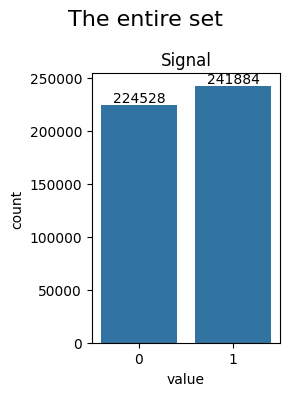

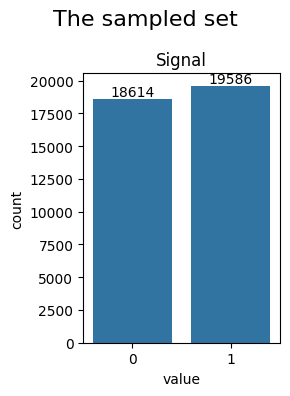

In [30]:
fig_a = plot_features_count(pd.DataFrame(y_train), ['signal'], figsize=(3,4), ncols=1, suptitle='The entire set')
fig_s = plot_features_count(pd.DataFrame(y_train_small), ['signal'], figsize=(3,4), ncols=1, suptitle='The sampled set')
display(fig_a, fig_s)

## Estimator selection

### Select transformer and dimention reducer

#### Classifiers and hyperparameters.

Define a list of classifiers and hyperparameters to grid search over

In [31]:
sklearn_classifiers_t_r = [
    {
        'model':LogisticRegression, 
        'params': {
            'C': [1, 1.5], #[0.05, 0.1, 0.2, 0.5, 1, 1.2, 1.8],
            'solver': ['saga'], #['sag', 'saga', 'lbfgs', 'newton-cholesky'],
        }
    },
    {
        'model':GaussianNB, 
        'params': {
            'var_smoothing': [1e-11, 1e-09, 1e-06],
        }
    },
    {
        'model':RandomForestClassifier, 
        'params': {
            'max_depth': [2, None], 
        }
    },          

    {
        'model':HistGradientBoostingClassifier,
        'params': {
            'max_depth': [5, None], #[5, 10, 20, 50, None],
        }
    }
]

dim_reducers_t_r = [{'model': FastICA(), 'params': {'n_components': [2,5,8, None]}}, {'model': 'passthrough', 'params':{}}]

Define a list of train set lengths to grid search over 

In [32]:
train_set_lengths = [time_series_split_min_train_set, (time_series_split_max_train_set+time_series_split_min_train_set)//2, time_series_split_max_train_set]
#train_set_lengths = [100, 500]

#### GridSearch

Run grid search on the list of classifiers.

In [33]:
results_file_t_r = os.path.join(pkl_dir, 'gridsearch_results_t_r.pkl')
grid_search_results_t_r = train_classifiers(results_file=results_file_t_r,
                                         classifiers=sklearn_classifiers_t_r,
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking,
                                         column_transformers=list(column_transformers.values()),
                                         configed_dim_reducers=dim_reducers_t_r,
                                         train_set_lengths=None, 
)

load trained models from ../results/pickled\gridsearch_results_t_r.pkl
Model logisticregression:
With parameters: [{'logisticregression__C': [1, 1.5], 'logisticregression__solver': ['saga'], 'transformer': [ordinal_std_quantile_power_kbins_u, ordinal_std_quantile_power_kbins_q, ordinal_quantile_power_kbins_u, ordinal_quantile_power_kbins_q, ordinal_quantile_power, ordinal_no_transform_digit_cols, ordinal_max_abs_not_indicators, ordinal_standard_not_indicators, ordinal_standard, ordinal_standard_robust, ordinal_robust_not_indicators, target_std_quantile_power_kbins_u, target_std_quantile_power_kbins_q, target_quantile_power_kbins_u, target_quantile_power_kbins_q, target_quantile_power, target_no_transform_digit_cols, target_max_abs_not_indicators, target_standard_not_indicators, target_standard, target_standard_robust, target_robust_not_indicators, drop_std_quantile_power_kbins_u, drop_std_quantile_power_kbins_q, drop_quantile_power_kbins_u, drop_quantile_power_kbins_q, drop_quantile_po

#### Analyze results 

Analyze results of grid search for different classifiers

In [34]:
key_results_file = os.path.join(results_dir, 'key_results.md')

with open(key_results_file, 'w', encoding='utf-8') as f: 
    f.write('# Results of GridSearchCV\n')

save_grid_search_key_results = lambda grid_search_results, stage: add_grid_search_key_results(grid_search_results, stage, key_results_file)

In [35]:
save_grid_search_key_results(grid_search_results_t_r, 'Select transformer and dimention reducer')

--- data is saved to ../results/key_results.md ---


In [36]:
score_file = os.path.join(results_dir,'ml_metrics_train.md')

with open(score_file, 'w', encoding='utf-8') as f: 
    f.write('# Scores of best estimators chosen by GridSearchCV\n')

save_scores_of_stage_to_file = lambda grid_search_results, stage: add_scores_of_stage_to_file(grid_search_results, stage, file_path=score_file, scores=scores, confusion_matrix_cells=confusion_matrix_cells)

In [37]:
save_scores_of_stage_to_file(grid_search_results_t_r, 'Select transformer and dimention reducer')

logisticregression
gaussiannb
randomforestclassifier
histgradientboostingclassifier
Saving logisticregression
({'logisticregression...
Saving gaussiannb
({'gaussiannb__var_smoothing'...
Saving randomforestclassifier
({'randomforestcl...
Saving histgradientboostingclassifier
({'histgr...
--- data is saved to ../results/ml_metrics_train.md ---


Take a close look to the "worst" splits

In [38]:
accuracy_roc_file = os.path.join(results_dir,'ml_metrics_train_accuracy_roc.md')
with open(accuracy_roc_file, 'w', encoding='utf-8') as f: 
    f.write('## Select transformer and dimention reducer\n')
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_t_r:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving logisticregression...
Saving gaussiannb...
Saving randomforestclassifier...
Saving histgradientboostingclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [39]:
weigths_split7_file = os.path.join(results_dir,'scores_on_split7.md')
with open(weigths_split7_file, 'w', encoding='utf-8') as f: 
    f.write('## Stage 1\n')
distr_weight_on_split7 = {}
for grid_search_result in grid_search_results_t_r:
    model_name = grid_search_result['name']
    distr_weight_on_split7[model_name] = cv_scores_on_splits_per_param(grid_search_result['grid_search'], par_name=f'{model_name}__class_weight',  scores='roc_auc', splits=7)
add_data_frames_to_file(weigths_split7_file, distr_weight_on_split7)

Saving logisticregression...
Saving gaussiannb...
Saving randomforestclassifier...
Saving histgradientboostingclassifier...
--- data is saved to ../results/scores_on_split7.md ---


In [40]:
rocauc_by_splits_t_r_file = os.path.join(results_dir,'best_models_scores_roc_auc_t_r.png')
snsplot = lineplot(concatenate_estimators_scores(grid_search_results_t_r).reset_index(), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models') 
snsplot.figure.savefig(rocauc_by_splits_t_r_file)
print('ROC_AUC scores of the best models are saved into ', paint(rocauc_by_splits_t_r_file, format))

ROC_AUC scores of the best models are saved into  ../results/best_models_scores_roc_auc_t_r.png


In [41]:
transformer_comparation, best_transformers = create_tables_of_scores_by_param(grid_search_results_t_r, par_names='transformer', key='scores_by_transformers')
print_scores_by_param(transformer_comparation, best_transformers, 'transformer', model_names_prune=10, param_values_prune=None)

****Splitwise mean of roc_auc scores for each transformer and the best value for the other parametrs****

Best parameters: logisticregression: drop_standard_not_indicators
Best parameters: gaussiannb: ordinal_standard_not_indicators
Best parameters: randomforestclassifier: drop_standard_robust
Best parameters: histgradientboostingclassifier: ordinal_no_transform_digit_cols

Model name                         gaussiannb           histgradie            \
                                        train      test      train      test   
drop_max_abs_not_indicators          0.511852  0.508805   0.585714  0.509561   
drop_no_transform_digit_cols         0.511625  0.514348   0.577601  0.510335   
drop_quantile_power                  0.515086  0.512573   0.600021  0.499905   
drop_quantile_power_kbins_q          0.517028  0.514295   0.587545  0.517972   
drop_quantile_power_kbins_u          0.517525  0.513803   0.584491  0.507029   
drop_robust_not_indicators           0.510540  0.517647   0.578

In [42]:
par_names = {f'reduce_dim__{param_name}' for dim_reducer in dim_reducers_t_r for param_name in dim_reducer['params'].keys() }
reducer_comparation, best_reducer = create_tables_of_scores_by_param(grid_search_results_t_r, par_names=['reduce_dim',*par_names], key='scores_by_dim_reducers')
print_scores_by_param(reducer_comparation, best_reducer, 'dimention reducer', model_names_prune=10)

****Splitwise mean of roc_auc scores for each dimention reducer and the best value for the other parametrs****

Best parameters: logisticregression: {'reduce_dim': "FastICA() ({'n_components': 2})", 'reduce_dim__n_components': '2'}
Best parameters: gaussiannb: {'reduce_dim': "FastICA() ({'n_components': 5})", 'reduce_dim__n_components': '5'}
Best parameters: randomforestclassifier: {'reduce_dim': 'passthrough', 'reduce_dim__n_components': '-'}
Best parameters: histgradientboostingclassifier: {'reduce_dim': "FastICA() ({'n_components': 5})", 'reduce_dim__n_components': '5'}

Model name                           gaussiannb           histgradie  \
                                          train      test      train   
reduce_dim  reduce_dim__n_components                                   
FastICA()   2                          0.512353  0.521555   0.554066   
            5                          0.514097  0.523111   0.573388   
            8                          0.517087  0.518174  

In [43]:
rocauc_by_splits_t_r_file = os.path.join(results_dir,'roc_auc_t_r.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_t_r), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models', figsize=(11, 4)) 

#plot by transformers
by='transformer'
#renamer_transformers = {str(name): name.__class__.__name__.rstrip('DigitCols').replace('Indicator','Indic') for name in column_transformers}
df_to_plot = transformer_comparation.reset_index(names=by)
snsplot_transformer = plot_validation_by(df_to_plot, by=by, by_axis='y', figsize=(11, 6))

#plot by reducers
by='reducer'
df_to_plot = reducer_comparation.reset_index()
df_to_plot[by]=df_to_plot['reduce_dim'].astype(str) + '_' + df_to_plot['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
snsplot_reducer = plot_validation_by(df_to_plot, by=by) 

with PdfPages(rocauc_by_splits_t_r_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_transformer.figure.savefig(pdf, format='pdf')
    snsplot_reducer.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_t_r_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_t_r.pdf


### Cross validation with 25 folds

#### Build cross validation

In [44]:
validation_set_size_11=11
n_splits_11=25

tscv_blocking_11 = MultiTimeSeriesSplit(n_splits=n_splits_11, 
                                     max_train_size=max_train_size, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size_11, 
                                     gap=0)

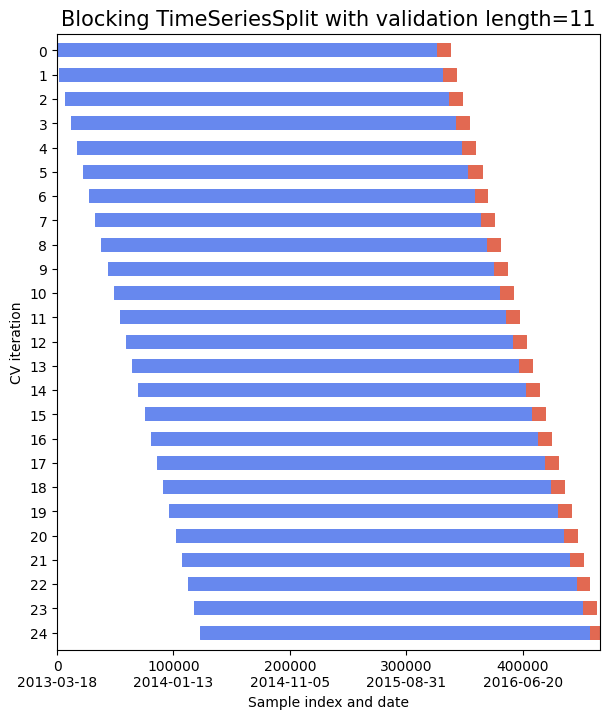

In [45]:
fig = plot_cv(tscv_blocking_11, f'Blocking TimeSeriesSplit with validation length={validation_set_size_11}', X_train, y_train, scale_x=500, figsize=(7, 8))   
display(fig)

In [46]:
print(f'Minimum length of the train sets {paint('(number of days)',format)} in the cross-validation above: {paint(tscv_blocking_11.get_min_train_size(), format)}')
print(f'Length of train folds, companies in the fold:')
i = 0
end=' -> '
for train_idxs, _ in tscv_blocking_11.split(X_train):
    if i == n_splits_11-1:
        end = '\n'
    print(f'{i}: {len(X_train.iloc[train_idxs])}, {len(X_train.iloc[train_idxs]['Name'].unique())}', end=end)
    i += 1

Minimum length of the train sets (number of days) in the cross-validation above: 504
Length of train folds, companies in the fold:
0: 329822, 494 -> 1: 330020, 494 -> 2: 330222, 495 -> 3: 330435, 495 -> 4: 330644, 495 -> 5: 330857, 496 -> 6: 331074, 496 -> 7: 331283, 496 -> 8: 331491, 496 -> 9: 331653, 496 -> 10: 331807, 496 -> 11: 331967, 497 -> 12: 332141, 497 -> 13: 332306, 497 -> 14: 332471, 497 -> 15: 332636, 497 -> 16: 332802, 498 -> 17: 332978, 498 -> 18: 333152, 498 -> 19: 333317, 498 -> 20: 333482, 498 -> 21: 333647, 498 -> 22: 333812, 498 -> 23: 333977, 498 -> 24: 334142, 498


In [47]:
print(f'Do the train and test folds contain data from the same day: {paint(is_train_test_folds_have_common_dates(tscv_blocking, X_train), format)}')

Do the train and test folds contain data from the same day: False


#### Classifiers and hyperparameters.

Define a list of classifiers and hyperparameters to grid search over

In [48]:
sklearn_classifiers_cv = [
    {
        'model':LogisticRegression, 
        'params': {
            'C': [1.5], #[0.05, 0.1, 0.2, 0.5, 1, 1.2, 1.8],
            'solver': ['saga'], #['sag', 'saga', 'lbfgs', 'newton-cholesky'],
        }
    },
    {
        'model':GaussianNB, 
        'params': {
            'var_smoothing': [1e-11, 1e-06],
        }
    },
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [2], 
        }
    },          
    {
        'model':HistGradientBoostingClassifier,
        'params': {
            'max_depth': [10, None], #[5, 10, 20, 50, None],
        }
    }
]


In [49]:

kbins_uniform_20 = KBinsDiscretizer(n_bins=20, strategy='uniform')
kbins_quantile_20 = KBinsDiscretizer(n_bins=20, strategy='quantile')
kbins_u20 = [NamedTransformer(name='ordinal_std_quantile_power_kbins_u20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                        (power_transformer, power_transformer_cols), 
                                                        (kbins_uniform_20, kbins_discretizer_cols), 
                                                        (quantile_transformer, quantile_transformer_cols)], 
                                  encoder_columns=['Name'],
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas'),
             NamedTransformer(name='ordinal_quantile_power_kbins_u20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(power_transformer, power_transformer_cols), 
                                                        (kbins_uniform_20, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                  encoder_columns=['Name'],
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')]
kbins_q20 = [NamedTransformer(name='ordinal_std_quantile_power_kbins_q20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                        (power_transformer, power_transformer_cols), 
                                                        (kbins_quantile_20, kbins_discretizer_cols), 
                                                        (quantile_transformer, quantile_transformer_cols)], 
                                  encoder_columns=['Name'],
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas'),
             NamedTransformer(name='ordinal_quantile_power_kbins_q20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(power_transformer, power_transformer_cols), 
                                                        (kbins_quantile_20, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                  encoder_columns=['Name'],
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')]


scaler_continuoses = ColumnTransformer([('std_scaler', std_scaler, standard_scaling_cols+quantile_transformer_cols+power_transformer_cols)], 
                        verbose_feature_names_out=False, remainder='passthrough').set_output(transform='pandas')
column_transformers_cv = {'logisticregression': [column_transformers['ordinal_std_quantile_power_kbins_u'],
                                                 column_transformers['ordinal_quantile_power_kbins_u'],
                                                 *kbins_u20],
                          'gaussiannb': [column_transformers['target_standard']],
                          'randomforestclassifier': [column_transformers['ordinal_std_quantile_power_kbins_q'],
                                                    column_transformers['ordinal_quantile_power_kbins_q'],
                                                    *kbins_q20,],
                          'histgradientboostingclassifier': [column_transformers['ordinal_std_quantile_power_kbins_u'], 
                                                             kbins_u20[0]],
                          }
for name_, transformers in column_transformers_cv.items():
    if name_ != 'gaussiannb':
        transform_scales = [NamedTransformer(name=f'{transformer}_scl', transformer=Pipeline([('transformer', transformer), ('scaler', scaler_continuoses)])) 
                       for transformer in transformers]
        transformers += transform_scales

dim_reducers_cv = [{'model': FastICA(), 'params': {'n_components': [2]}}]

Define a list of train set lengths to grid search over 

In [50]:
train_set_lengths_cv = [days_in_2years_history*n_orgs_small, (days_in_2years_history+max_train_size)*n_orgs_small//2, max_train_size*n_orgs_small]

In [51]:
train_set_lengths_cv

[20160, 23680, 27200]

#### GridSearch

Run grid search on the list of classifiers.

In [52]:
results_file_cv = os.path.join(pkl_dir, 'gridsearch_results_cv.pkl')
grid_search_results_cv = train_classifiers(results_file=results_file_cv,
                                         classifiers=sklearn_classifiers_cv,
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking_11,
                                         column_transformers=column_transformers_cv,
                                         configed_dim_reducers=dim_reducers_cv,
                                         train_set_lengths=train_set_lengths_cv, 
)

load trained models from ../results/pickled\gridsearch_results_cv.pkl
Model logisticregression:
With parameters: [{'logisticregression__C': [1.5], 'logisticregression__solver': ['saga'], 'logisticregression__train_length': [20160, 23680, 27200], 'transformer': [ordinal_std_quantile_power_kbins_u, ordinal_quantile_power_kbins_u, ordinal_std_quantile_power_kbins_u20, ordinal_quantile_power_kbins_u20, ordinal_std_quantile_power_kbins_u_scl, ordinal_quantile_power_kbins_u_scl, ordinal_std_quantile_power_kbins_u20_scl, ordinal_quantile_power_kbins_u20_scl], 'reduce_dim': [FastICA()], 'reduce_dim__n_components': [2]}]

Best parameters: {'logisticregression__C': 1.5, 'logisticregression__solver': 'saga', 'logisticregression__train_length': 27200, 'reduce_dim': FastICA(), 'reduce_dim__n_components': 2, 'transformer': ordinal_quantile_power_kbins_u20}
Best scores: 0.5169104195029943
Search time: 4.94327813500034 minutes
Model gaussiannb:
With parameters: [{'gaussiannb__var_smoothing': [1e-11, 1

#### Analyze results 

Analyze results of grid search for different classifiers

In [53]:
save_grid_search_key_results(grid_search_results_cv, 'CV 25 folds, 11 days validation')
save_scores_of_stage_to_file(grid_search_results_cv, 'CV 25 folds, 11 days validation')

--- data is saved to ../results/key_results.md ---
logisticregression
gaussiannb
randomforestclassifier
histgradientboostingclassifier
Saving logisticregression
({'logisticregression...
Saving gaussiannb
({'gaussiannb__train_length':...
Saving randomforestclassifier
({'randomforestcl...
Saving histgradientboostingclassifier
({'histgr...
--- data is saved to ../results/ml_metrics_train.md ---


In [54]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write('## CV 25 folds, 11 days validation\n')
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_cv:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving logisticregression...
Saving gaussiannb...
Saving randomforestclassifier...
Saving histgradientboostingclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [55]:
comparation_table = create_comparation_table([grid_search_results_t_r, grid_search_results_cv, ],
                          ['transf-scaler', 'CV', ],
                          [res['name'] for res in grid_search_results_cv], 
                          ['score', 'transformer', 'reduce_dim'])
comparation_table#[comparation_table['diff'] != 'Same']

transf-scaler  \
model                          param                                                                   
gaussiannb                     n_components_best                                                   5   
                               n_components_grid                                     [2, 5, 8, None]   
                               reduce_dim_best                                             FastICA()   
                               reduce_dim_grid                            [FastICA(), 'passthrough']   
                               score                                                        0.523111   
                               train_length_best                                                 NaN   
                               train_length_grid                                                 NaN   
                               transformer_best                      ordinal_standard_not_indicators   
                               transformer_grid    [ordinal_std_quantile_power_kbins_u, ordinal_s...   
                               var_smoothing_best                                              1e-11   
                               var_smoothing_grid                              [1e-11, 1e-09, 1e-06]   
histgradientboostingclassifier max_depth_best                                                      5   
                               max_depth_grid                                              [5, None]   
                               n_components_best                                                   5   
                               n_components_grid                                     [2, 5, 8, None]   
                               reduce_dim_best                                             FastICA()   
                               reduce_dim_grid                            [FastICA(), 'passthrough']   
                               score                                                           0.525   
                               train_length_best                                                 NaN   
                               train_length_grid                                                 NaN   
                               transformer_best                      ordinal_no_transform_digit_cols   
                               transformer_grid    [ordinal_std_quantile_power_kbins_u, ordinal_s...   
logisticregression             C_best                                                            1.5   
                               C_grid                                                       [1, 1.5]   
                               n_components_best                                                   2   
                               n_components_grid                                     [2, 5, 8, None]   
                               reduce_dim_best                                             FastICA()   
                               reduce_dim_grid                            [FastICA(), 'passthrough']   
                               score                                                        0.519968   
                               solver_best                                                      saga   
                               solver_grid                                                  ['saga']   
                               train_length_best                                                 NaN   
                               train_length_grid                                                 NaN   
                               transformer_best                         drop_standard_not_indicators   
                               transformer_grid    [ordinal_std_quantile_power_kbins_u, ordinal_s...   
randomforestclassifier         max_depth_best                                                      2   
                               max_depth_grid                                              [2, None]   
                               

In [56]:
transformer_comparation, best_transformers = create_tables_of_scores_by_param(grid_search_results_cv, par_names='transformer', key='scores_by_transformers')
print_scores_by_param(transformer_comparation, best_transformers, 'transformer', model_names_prune=10, param_values_prune=None)

****Splitwise mean of roc_auc scores for each transformer and the best value for the other parametrs****

Best parameters: logisticregression: ordinal_quantile_power_kbins_u20
Best parameters: gaussiannb: target_standard
Best parameters: randomforestclassifier: ordinal_std_quantile_power_kbins_q20
Best parameters: histgradientboostingclassifier: ordinal_std_quantile_power_kbins_u20_scl

Model name                               gaussiannb           histgradie  \
                                              train      test      train   
ordinal_quantile_power_kbins_q                  NaN       NaN        NaN   
ordinal_quantile_power_kbins_q20                NaN       NaN        NaN   
ordinal_quantile_power_kbins_q20_scl            NaN       NaN        NaN   
ordinal_quantile_power_kbins_q_scl              NaN       NaN        NaN   
ordinal_quantile_power_kbins_u                  NaN       NaN        NaN   
ordinal_quantile_power_kbins_u20                NaN       NaN        NaN   
or

In [57]:
train_length_comparation, best_train_length = create_tables_of_scores_by_param(grid_search_results_cv, par_names='train_length', key='scores_by_train_length')
print_scores_by_param(train_length_comparation, best_train_length, 'train_length', model_names_prune=10)

****Splitwise mean of roc_auc scores for each train_length and the best value for the other parametrs****

Best parameters: logisticregression: 27200
Best parameters: gaussiannb: 27200
Best parameters: randomforestclassifier: 23680
Best parameters: histgradientboostingclassifier: 27200

Model name gaussiannb           histgradie           logisticre            \
                train      test      train      test      train      test   
20160        0.509639  0.516006   0.565229  0.508517   0.512404  0.515062   
23680        0.510865  0.516313   0.571231  0.511767   0.512580  0.515962   
27200        0.511978  0.518798   0.579590  0.515096   0.512675  0.516910   

Model name randomfore            
                train      test  
20160        0.525601  0.516121  
23680        0.526618  0.522328  
27200        0.527630  0.518849  


In [58]:
rocauc_by_splits_cv_file = os.path.join(results_dir,'roc_auc_cv.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_cv), x='split',  y='roc_auc',style='set', rotation_ticks=True, title='Compare ROC_AUC of the best models', figsize=(11, 4)) 


#plot by transformer
by='transformer'
def renamer_transformers(s):
    letters = [word[0] for word in s.split('_')]
    if s[-2:].isdigit():
        letters.append(s[-2:])
    return ''.join(letters)
df_to_plot = transformer_comparation.rename(index=renamer_transformers).reset_index(names=by)
snsplot_transformer = plot_validation_by(df_to_plot, by=by,  by_axis='y', figsize=(11, 5))
#plot by train_length
by='train_length'
df_to_plot = train_length_comparation.reset_index(names=by)
snsplot_train_length = plot_validation_by(df_to_plot, by=by) 
with PdfPages(rocauc_by_splits_cv_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_transformer.figure.savefig(pdf, format='pdf')
    snsplot_train_length.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_cv_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_cv.pdf


### Compare LogisticRegression and RandomForestClassifier

#### Classifiers and hyperparameters.

In [59]:
configer_classifier_cls=[
    {
        'model':LogisticRegression, 
        'params': {
            'C': [0.5, 1, 1.5, 1.8, 2],
            'solver': ['sag', 'saga', 'lbfgs', 'newton-cholesky', 'newton-cg'],
            'max_iter': [100, 200],
        }
    },
    {
        'model':SGDClassifier, 
        'params': {
            'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error'],
            'penalty': ['l2', 'l1', 'elasticnet'],
        }
    },
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [100, 150, 200],
            'min_samples_split': [2, 3, 4], 
            'min_samples_leaf': [1, 2, 3], 
            'max_features': ["sqrt", "log2", None],
            'max_depth': [2, 3],
        }
    },
]
column_transformers_cls = {'logisticregression': column_transformers['ordinal_std_quantile_power_kbins_u'],
                          'randomforestclassifier': column_transformers['ordinal_std_quantile_power_kbins_q'],
                          'sgdclassifier': column_transformers['ordinal_std_quantile_power_kbins_u'],
                        }

dim_reducers_cls = {'model': FastICA(), 'params': {'n_components': [2]}}
n_orgs_train = X_train['Name'].nunique()
lenght_start = (days_in_2years_history)*n_orgs_train
lenght_end = max_train_size * n_orgs_train
length_diff = lenght_end - lenght_start
train_set_lengths_cls = [length+2 for length in range(lenght_start, lenght_end, length_diff//3)]
train_set_lengths_cls.append(lenght_end)

In [60]:
train_set_lengths_cls

[250994, 280210, 309426, 338640]

#### GridSearch

In [61]:
results_file_cls= os.path.join(pkl_dir,'gridsearch_results_cls.pkl' )
grid_search_results_cls = train_classifiers(results_file=results_file_cls,
                                         classifiers=configer_classifier_cls,
                                         X=X_train, y=y_train,
                                         scoring=scorer, 
                                         cv=tscv_blocking,
                                         column_transformers=column_transformers_cls,
                                         configed_dim_reducers=dim_reducers_cls,
                                         train_set_lengths=train_set_lengths_cls,
                                         error_score='raise',
)

load trained models from ../results/pickled\gridsearch_results_cls.pkl
Model logisticregression:
With parameters: {'logisticregression__C': [0.5, 1, 1.5, 1.8, 2], 'logisticregression__solver': ['sag', 'saga', 'lbfgs', 'newton-cholesky', 'newton-cg'], 'logisticregression__max_iter': [100, 200], 'logisticregression__train_length': [250994, 280210, 309426, 338640], 'reduce_dim__n_components': [2]}

Best parameters: {'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'saga', 'logisticregression__train_length': 338640, 'reduce_dim__n_components': 2}
Best scores: 0.529169836068199
Search time: 156.8787384399989 minutes
Model sgdclassifier:
With parameters: {'sgdclassifier__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error'], 'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'], 'sgdclassifier__train_length': [250994, 280210, 309426, 338640], 'reduce_dim__n_components': [2]}

Best parameters: {'reduce_dim__

#### Analyze results

In [62]:
save_grid_search_key_results(grid_search_results_cls, 'Choose hyperparameters')
save_scores_of_stage_to_file(grid_search_results_cls, 'Choose hyperparameters')

--- data is saved to ../results/key_results.md ---
logisticregression
sgdclassifier
randomforestclassifier
Saving logisticregression
({'logisticregression...
Saving sgdclassifier
({'reduce_dim__n_component...
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [63]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write('## Choose hyperparameters\n')
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_cls:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving logisticregression...
Saving sgdclassifier...
Saving randomforestclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [64]:
comparation_table = create_comparation_table([grid_search_results_t_r, grid_search_results_cv, grid_search_results_cls],
                          ['transf-scaler', 'CV', 'hyperparams'],
                          ['logisticregression', 'randomforestclassifier',], 
                          ['score', 'transformer', ])
comparation_table#[comparation_table['diff'] != 'Same']

transf-scaler  \
model                  param                                                                       
logisticregression     C_best                                                                1.5   
                       C_grid                                                           [1, 1.5]   
                       max_iter_best                                                         NaN   
                       max_iter_grid                                                         NaN   
                       score                                                            0.519968   
                       solver_best                                                          saga   
                       solver_grid                                                      ['saga']   
                       train_length_best                                                     NaN   
                       train_length_grid                                                     NaN   
                       transformer_best                             drop_standard_not_indicators   
                       transformer_grid        [ordinal_std_quantile_power_kbins_u, ordinal_s...   
randomforestclassifier max_depth_best                                                          2   
                       max_depth_grid                                                  [2, None]   
                       max_features_best                                                     NaN   
                       max_features_grid                                                     NaN   
                       min_samples_leaf_best                                                 NaN   
                       min_samples_leaf_grid                                                 NaN   
                       min_samples_split_best                                                NaN   
                       min_samples_split_grid                                                NaN   
                       n_estimators_best                                                     NaN   
                       n_estimators_grid                                                     NaN   
                       score                                                            0.524476   
                       train_length_best                                                     NaN   
                       train_length_grid                                                     NaN   
                       transformer_best                                     drop_standard_robust   
                       transformer_grid        [ordinal_std_quantile_power_kbins_u, ordinal_s...   

                                                                                              CV  \
model                  param                                                                       
logisticregression     C_best                                                                1.5   
                       C_grid                                                              [1.5]   
                       max_iter_best                                                         NaN   
                       max_iter_grid                                                         NaN   
                       score                                                             0.51691   
                       solver_best                                                          saga   
                       solver_grid                                                      ['saga']   
                       train_length_best                                                   27200   
                       train_length_grid                                   [20160, 23680, 27200]   
                       transformer_best                         ordinal_quantile_power_kbins_u20   
                       transformer_grid        [ordinal_std_quantile_power_kbins_u

In [65]:
train_length_comparation, best_train_length = create_tables_of_scores_by_param(grid_search_results_cls, par_names='train_length', key='scores_by_train_length')
print_scores_by_param(train_length_comparation, best_train_length, 'train_length', model_names_prune=10)

****Splitwise mean of roc_auc scores for each train_length and the best value for the other parametrs****

Best parameters: logisticregression: 338640
Best parameters: sgdclassifier: 280210
Best parameters: randomforestclassifier: 280210

Model name logisticre           randomfore           sgdclassif          
                train      test      train      test      train      test
250994       0.513448  0.528850   0.514357  0.529010   0.508485  0.517017
280210       0.513462  0.529004   0.514471  0.530144   0.513460  0.529157
309426       0.513470  0.529059   0.514327  0.529457   0.511279  0.524661
338640       0.513469  0.529170   0.514173  0.529146   0.511079  0.527931


In [66]:
min_samples_leaf_comparation, best_min_samples_leaf = create_tables_of_scores_by_param([grid_search_results_cls[2]], par_names='min_samples_leaf', key='scores_by_min_samples_leaf')
print_scores_by_param(min_samples_leaf_comparation, best_min_samples_leaf, 'min_samples_leaf', model_names_prune=10)

****Splitwise mean of roc_auc scores for each min_samples_leaf and the best value for the other parametrs****

Best parameters: randomforestclassifier: 3

Model name randomfore          
                train      test
1            0.514348  0.529695
2            0.514424  0.529455
3            0.514471  0.530144


In [67]:
n_estimators_comparation, best_n_estimators = create_tables_of_scores_by_param([grid_search_results_cls[2]], par_names='n_estimators', key='scores_by_n_estimators')
print_scores_by_param(n_estimators_comparation, best_n_estimators, 'n_estimators', model_names_prune=10)

****Splitwise mean of roc_auc scores for each n_estimators and the best value for the other parametrs****

Best parameters: randomforestclassifier: 100

Model name randomfore          
                train      test
100          0.514471  0.530144
150          0.514415  0.529740
200          0.514532  0.529705


In [68]:
max_features_comparation, best_max_features = create_tables_of_scores_by_param([grid_search_results_cls[2]], par_names='max_features', key='scores_by_max_features')
print_scores_by_param(max_features_comparation, best_max_features, 'max_features', model_names_prune=10)

****Splitwise mean of roc_auc scores for each max_features and the best value for the other parametrs****

Best parameters: randomforestclassifier: None

Model name randomfore          
                train      test
None         0.514471  0.530144
log2         0.515179  0.528984
sqrt         0.515060  0.528584


In [69]:
rocauc_by_splits_cls_file = os.path.join(results_dir,'roc_auc_cls.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_cls), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models', figsize=(11, 4)) 


#plot by train_length
by='train_length'
df_to_plot = train_length_comparation.reset_index(names=by)
snsplot_train_length = plot_validation_by(df_to_plot, by=by) 
#plot by min_samples_leaf
by='min_samples_leaf'
df_to_plot = min_samples_leaf_comparation.reset_index(names=by)
snsplot_min_samples_leaf = plot_validation_by(df_to_plot, by=by) 
#plot by n_estimators
by='n_estimators'
df_to_plot = n_estimators_comparation.reset_index(names=by)
snsplot_n_estimators = plot_validation_by(df_to_plot, by=by) 
#plot by max_features
by='max_features'
df_to_plot = max_features_comparation.reset_index(names=by)
snsplot_max_features = plot_validation_by(df_to_plot, by=by) 
with PdfPages(rocauc_by_splits_cls_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_train_length.figure.savefig(pdf, format='pdf')
    snsplot_min_samples_leaf.figure.savefig(pdf, format='pdf')
    snsplot_n_estimators.figure.savefig(pdf, format='pdf')
    snsplot_max_features.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_cls_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_cls.pdf


#### Plot validation curves

Get data for validation_curve

In [70]:
for grid_search_result in grid_search_results_cls:
    grid_search_result['validation_curve_data'] = cv_scores(grid_search_result['grid_search'], score='roc_auc')

In [71]:
figs = []
for grid_search_result in grid_search_results_cls:
    title = grid_search_result['name']
    data = grid_search_result['validation_curve_data']
    figs.append(plot_validation_curves(data, grid_search_result['grid_search'].best_params_, title, exclude_params=['reduce_dim__n_components']))

In [72]:
validation_plots_cls_file = os.path.join(results_dir, 'validation_plots_cls.pdf')
with PdfPages(validation_plots_cls_file) as pdf:
    for fig in figs:
        pdf.savefig(fig)
print(f'Validation plots saved to {paint(validation_plots_cls_file, format)}') 

Validation plots saved to ../results/validation_plots_cls.pdf


### GridSearch RandomForestClassifier

#### Classifiers and hyperparameters.

In [73]:
configer_classifier_rf=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [200, 250, 300],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': [3,5,6], 
            'max_features': [None],
            'max_depth': [3, 4, 5],
        }
    },
]
column_transformers_rf = column_transformers['ordinal_std_quantile_power_kbins_q']

dim_reducers_rf = {'model': FastICA(), 'params': {'n_components': [2]}}
train_set_lengths_rf = [265602, 280210, 300462]

#### GridSearch

In [74]:
results_file_rf= os.path.join(pkl_dir,'gridsearch_results_rf.pkl' )
grid_search_results_rf = train_classifiers(results_file=results_file_rf,
                                         classifiers=configer_classifier_rf,
                                         X=X_train, y=y_train, 
                                         scoring=scorer, 
                                         cv=tscv_blocking,
                                         column_transformers=column_transformers_rf,
                                         configed_dim_reducers=dim_reducers_rf,
                                         train_set_lengths=train_set_lengths_rf, 
)

load trained models from ../results/pickled\gridsearch_results_rf.pkl
Model randomforestclassifier:
With parameters: {'randomforestclassifier__n_estimators': [200, 250, 300], 'randomforestclassifier__min_samples_leaf': [3, 5, 6], 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [3, 4, 5], 'randomforestclassifier__train_length': [265602, 280210, 300462], 'reduce_dim__n_components': [2]}

Best parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__train_length': 280210, 'reduce_dim__n_components': 2}
Best scores: 0.5300812738736321
Search time: 702.9265654899995 minutes


In [75]:
hyperparameters_file_best= os.path.join(pkl_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    for grid_search_result in grid_search_results_rf:
        f.write(f"{grid_search_result['name']}:\n")
        f.write(f"Best parameters: {grid_search_result['grid_search'].best_params_}\n")
        f.write(f"Best score: {grid_search_result['grid_search'].best_score_}\n")
        f.write(f"Grid serach time: {grid_search_result['search_time']/60} minutes")

#### Analyze results

In [76]:
save_grid_search_key_results(grid_search_results_rf, "Choose RandomForestClassifier's hyperparameters")
save_scores_of_stage_to_file(grid_search_results_rf, "Choose RandomForestClassifier's hyperparameters")

--- data is saved to ../results/key_results.md ---
randomforestclassifier
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [77]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write("## Choose RandomForestClassifier's hyperparameters \n")
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_rf:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving randomforestclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [78]:
comparation_table = create_comparation_table([grid_search_results_t_r, grid_search_results_cv, grid_search_results_cls, grid_search_results_rf],
                          ['transf-scaler', 'CV', 'hyperparams', 'RFC'],
                          ['randomforestclassifier',], 
                          ['score', ])
comparation_table#[comparation_table['diff'] != 'Same']

transf-scaler  \
model                  param                                  
randomforestclassifier max_depth_best                     2   
                       max_depth_grid             [2, None]   
                       max_features_best                NaN   
                       max_features_grid                NaN   
                       min_samples_leaf_best            NaN   
                       min_samples_leaf_grid            NaN   
                       min_samples_split_best           NaN   
                       min_samples_split_grid           NaN   
                       n_estimators_best                NaN   
                       n_estimators_grid                NaN   
                       score                       0.524476   
                       train_length_best                NaN   
                       train_length_grid                NaN   

                                                                  CV  \
model                  param                                           
randomforestclassifier max_depth_best                              2   
                       max_depth_grid                            [2]   
                       max_features_best                         NaN   
                       max_features_grid                         NaN   
                       min_samples_leaf_best                     NaN   
                       min_samples_leaf_grid                     NaN   
                       min_samples_split_best                    NaN   
                       min_samples_split_grid                    NaN   
                       n_estimators_best                         100   
                       n_estimators_grid                   [50, 100]   
                       score                                0.522328   
                       train_length_best                       23680   
                       train_length_grid       [20160, 23680, 27200]   

                                                                    hyperparams  \
model                  param                                                      
randomforestclassifier max_depth_best                                         2   
                       max_depth_grid                                    [2, 3]   
                       max_features_best                                   None   
                       max_features_grid                 ['sqrt', 'log2', None]   
                       min_samples_leaf_best                                  3   
                       min_samples_leaf_grid                          [1, 2, 3]   
                       min_samples_split_best                                 2   
                       min_samples_split_grid                         [2, 3, 4]   
                       n_estimators_best                                    100   
                       n_estimators_grid                        [100, 150, 200]   
                       score                                           0.530144   
                       train_length_best                                 280210   
                       train_length_grid       [250994, 280210, 309426, 338640]   

                                                                    RFC  \
model                  param                                              
randomforestclassifier max_depth_best                                 3   
                       max_depth_grid                         [3, 4, 5]   
                       max_features_best                           None   
                       max_features_grid                         [None]   
                       min_samples_leaf_best                          3   
                       min_samples_leaf_grid                  [3, 5, 6]   
                       min_samples_split_best                       NaN   
                       min_samples_split_grid                       NaN   
                       

In [79]:
training_params = ['n_estimators', 'min_samples_leaf', 'max_depth', 'train_length']
comparations, best_params  = create_train_test_comparation_tables(grid_search_results_rf, training_params)
titles = [f'Best {param_name}: {best_value}' for param_name, best_value in best_params.items()]
display_df_side_by_side(comparations.values(), titles)

,score,train,test,Model name
200,roc_auc,0.516865,0.530081,randomforestclassifier
250,roc_auc,0.516928,0.529475,randomforestclassifier
300,roc_auc,0.516919,0.529554,randomforestclassifier
200,accuracy,0.516979,0.515583,randomforestclassifier
250,accuracy,0.517113,0.515101,randomforestclassifier
300,accuracy,0.516950,0.515414,randomforestclassifier
,score,train,test,Model name
3,roc_auc,0.516865,0.530081,randomforestclassifier
5,roc_auc,0.516851,0.529625,randomforestclassifier
6,roc_auc,0.516895,0.529701,randomforestclassifier


In [80]:
rocauc_by_splits_rf_file = os.path.join(results_dir,'roc_auc_rf.pdf')
# plot by splits
data_to_plot = grid_search_results_rf[0][KEY_BEST_ESTIMATOR_SCORES].reset_index().melt(id_vars=['split', 'set'], value_vars=['roc_auc', 'accuracy'], var_name='score_kind', value_name='score')
snsplot_split = lineplot(data_to_plot, x='split',  y='score', style='set', hue='score_kind', title='Compare ROC_AUC of the best models', figsize=(11, 4)) 

snsplots = []
for param_name, comparation in comparations.items():   
    df_to_plot = comparation.reset_index(names=param_name)
    snsplots.append(plot_validation_by(df_to_plot, by=param_name, score_to_plot='ROC_AUC and accuracy', hue='score') )
with PdfPages(rocauc_by_splits_rf_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    for snsplot in snsplots:
        snsplot.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_rf_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf.pdf


In [81]:
rocauc_by_splits_and_params_rf_file = os.path.join(results_dir,'roc_auc_by_splits_and_params_rf.png')
data_to_plot, _ = cv_scores_on_splits(grid_search_results_rf[0]['grid_search'],scores=['roc_auc', 'accuracy'],confusion_matrix_cells=None,n=None)
data_to_plot = data_to_plot.reset_index()
data_to_plot = data_to_plot[data_to_plot['set']=='test']
fig, axs = plt.subplots(1, len(training_params), figsize=(15, 5))
for i, param in enumerate(training_params):
    sns.barplot(data=data_to_plot, x='split', y='roc_auc', hue=param, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=45)
fig.suptitle('ROC_AUC scores by hyperparameters and splits')
plt.close()
fig.savefig(rocauc_by_splits_and_params_rf_file)
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_and_params_rf_file, format))


plot of ROC_AUC scores are saved into  ../results/roc_auc_by_splits_and_params_rf.png


In [82]:
roc_auc_by_splits_file = os.path.join(results_dir,'roc_auc_by_splits.png')
scores_on_splits = cv_scores_on_splits_by_param(grid_search_results_rf[0]['grid_search'], 'reduce_dim__n_components')
df_to_plot = scores_on_splits.reset_index(names=['split', 'set']).rename(columns={2:'roc_auc'})

scores_by_split_file = os.path.join(results_dir,'scores_by_split.pdf')
snsplot = barplot(df_to_plot, x='split', y='roc_auc',hue='set', title='Compare ROC_AUC of RandomForestClassifier by splits and sets')
snsplot.figure.savefig(roc_auc_by_splits_file)
print('plot of ROC_AUC scores are saved into ', paint(roc_auc_by_splits_file, format))


plot of ROC_AUC scores are saved into  ../results/roc_auc_by_splits.png


### Tune Chosen Classifier


Write the chosen model's info into a file

In [83]:
grid_search_result_chosen=grid_search_results_rf[0]
grid_search_result_chosen['grid_search'].best_estimator_ = grid_search_result_chosen['grid_search'].best_estimator_
hyperparameters_file_best= os.path.join(results_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    f.write(f"{grid_search_result_chosen['name']}:\n")
    f.write(f"Best parameters: {grid_search_result_chosen['grid_search'].best_params_}\n")
    f.write(f"Best score: {grid_search_result_chosen['grid_search'].best_score_}\n")
    f.write(f"Grid serach time: {grid_search_result_chosen['search_time']/60} minutes\n")

    f.write(f"Reducer: {dim_reducers_rf}\n")
    f.write(f"Column transformer: {super(NamedTransformer, column_transformers_rf).__repr__()}\n")


#### TimeSeries split
Build Cross Validation with `max_train_size` corresponding to the best train_length.

In [84]:
best_train_length = grid_search_results_rf[0]['grid_search'].best_params_['randomforestclassifier__train_length']
days_in_best_train_length = len(X_train_dates[(X_train_dates.min()<=X_train_dates) & (X_train_dates<X_train.index[best_train_length])])

In [85]:
validation_set_size_chosen = 25
n_splits_chosen = 11
tscv_blocking_chosen = MultiTimeSeriesSplit(n_splits=n_splits_chosen, 
                                     max_train_size=days_in_best_train_length-1, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size_chosen, 
                                     gap=0)

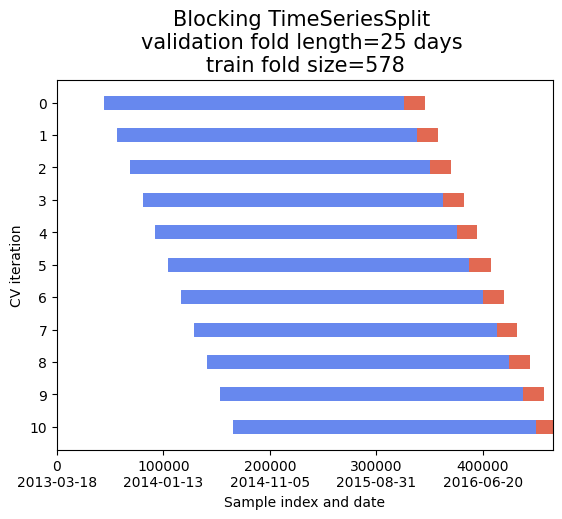

In [86]:
fig = plot_cv(tscv_blocking_chosen, 
              f'Blocking TimeSeriesSplit \nvalidation fold length={validation_set_size_chosen} days \ntrain fold size={days_in_best_train_length-1}',
              X_train, y_train, 
              scale_x=500)   
display(fig)

Check number of samples in the folds.

In [87]:

train_folds = [(train_sample_idxs[0], train_sample_idxs[-1], len(train_sample_idxs)) for train_sample_idxs, _ in tscv_blocking_chosen.split(X=X_train)]

print(f'{best_train_length=}')
print(f"Train folds' length:\n {'->'.join([f'[{fold[0]}--{fold[1]}({fold[2]})]' for fold in train_folds])}" )
for i, fold in enumerate(train_folds):
    if fold[2] != fold[1]-fold[0]+1:
        print(f'Caution {paint(f"fold {i} has wrong length", format)}: {fold[2]} != {fold[1]-fold[0]+1}')

best_train_length=280210
Train folds' length:
 [48649--329821(281173)]->[60690--342178(281489)]->[72740--354553(281814)]->[84790--366952(282163)]->[96846--379351(282506)]->[108921--391761(282841)]->[120996--404186(283191)]->[133071--416611(283541)]->[145167--429061(283895)]->[157288--441511(284224)]->[169423--453961(284539)]


#### Get rid of train size wrapper
Make pipeline with selected parameters, except for the train_length (it was used to make CV split) to eliminate the wrapper WrapTrainSizeParam.

In [88]:
model_params = {p_name.split('__')[-1]: p_val 
                for p_name, p_val in grid_search_result_chosen['grid_search'].best_params_.items() 
                if 'randomforestclassifier' in p_name and 'train_length' not in p_name
               }
reducer_params = {p_name.split('__')[-1]: p_val 
                for p_name, p_val in grid_search_result_chosen['grid_search'].best_params_.items() 
                if 'reduce_dim' in p_name 
               }


In [89]:
model_chosen = Pipeline([   ('transformer', column_transformers_rf),
                            ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_chosen

Pipeline(steps=[('transformer',
                 NamedTransformer(name='ordinal_std_quantile_power_kbins_q', transformer=EncoderNameScalerDigitCols(encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555), encoder_columns=['Name'], transformers_columns=[(StandardScaler(), ['rsi', 'cmf']), (PowerTransformer(), ['Bollinger_width']), (KBinsDiscretizer(n_bin...ollinger_mavg', 'pvo', 'macd', 'dpo', 'kst_diff', 'adi', 'force_index', 'ease_of_movement', 'sma_ease_of_movement', 'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'])], verbose_feature_names_out=False))),
                ('reduce_dim', FastICA(n_components=2)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_leaf=3,
                                        n_estimators=200))])

In [90]:
from sklearn.model_selection import LearningCurveDisplay
plot_file = os.path.join(results_dir, 'learning_curve_chosen_model.png')

if os.path.exists(plot_file):
    print(f'Learning Curve plot can be found at {paint(plot_file, format)} and will not be created again.')
else:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

    common_params = {
        "X": X_train,
        "y": y_train,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": tscv_blocking_chosen,
        "score_type": "both",
        "n_jobs": -1,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
    }
    score_names = ['accuracy', 'roc_auc']
    for i, score_name in enumerate(score_names):
        LearningCurveDisplay.from_estimator(model_chosen, **common_params, score_name=score_name, ax=ax[i])
        handles, label = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[:2], ["Training Score", "Test Score"])
        ax[i].set_title(f"Learning Curve for {score_name}")
    fig.suptitle("Learning Curves for Chosen Model", fontsize=16)
    fig.savefig(plot_file, format='png')
    fig.close()
    print(f'Learning Curve plot saved to {paint(plot_file, format)}')

Learning Curve plot can be found at ../results/learning_curve_chosen_model.png and will not be created again.


## 10 most important features

### 1. Feature Importance

To use RandomForest's property feature_importances_ we need to fit the model without the reducer, otherwise it shows only 'reduced' featuers (2 features).

In [95]:
first_train_fold_left = train_folds[0][0]
first_train_fold_right = train_folds[0][1]

In [96]:
first_train_fold_left, first_train_fold_right

(np.int64(48649), np.int64(329821))

In [97]:
model_chosen_no_reduce = Pipeline([   ('transformer', column_transformers_rf),
                            ('classifier', RandomForestClassifier(**model_params))])
model_chosen_no_reduce.fit(X_train[first_train_fold_left:first_train_fold_right+1], y_train[first_train_fold_left:first_train_fold_right+1])

c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and s

Pipeline(steps=[('transformer',
                 NamedTransformer(name='ordinal_std_quantile_power_kbins_q', transformer=EncoderNameScalerDigitCols(encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555), encoder_columns=['Name'], transformers_columns=[(StandardScaler(), ['rsi', 'cmf']), (PowerTransformer(), ['Bollinger_width']), (KBinsDiscretizer(n_bin...ormer(output_distribution='normal'), ['Bollinger_mavg', 'pvo', 'macd', 'dpo', 'kst_diff', 'adi', 'force_index', 'ease_of_movement', 'sma_ease_of_movement', 'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'])], verbose_feature_names_out=False))),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_leaf=3,
                                        n_estimators=200))])

In [98]:
feature_importances_plot_file = os.path.join(results_dir,'feature_importances.png')
feature_importances = model_chosen_no_reduce.named_steps['classifier'].feature_importances_
features = column_transformers_rf.fit(X_train).get_feature_names_out()
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
fig = plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.close()
fig.savefig(feature_importances_plot_file)
print('plot of feature importances are saved into ', paint(feature_importances_plot_file, format))


c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


plot of feature importances are saved into  ../results/feature_importances.png


### 2. Partial Dependence Plots (PDP)
Partial dependence plots show the relationship between a feature and the predicted outcome, marginalizing over the values of all other features.

In [99]:
model_chosen.fit(X_train[first_train_fold_left:first_train_fold_right+1], y_train[first_train_fold_left:first_train_fold_right+1])

c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and s

Pipeline(steps=[('transformer',
                 NamedTransformer(name='ordinal_std_quantile_power_kbins_q', transformer=EncoderNameScalerDigitCols(encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555), encoder_columns=['Name'], transformers_columns=[(StandardScaler(), ['rsi', 'cmf']), (PowerTransformer(), ['Bollinger_width']), (KBinsDiscretizer(n_bin...ollinger_mavg', 'pvo', 'macd', 'dpo', 'kst_diff', 'adi', 'force_index', 'ease_of_movement', 'sma_ease_of_movement', 'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'])], verbose_feature_names_out=False))),
                ('reduce_dim', FastICA(n_components=2)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_leaf=3,
                                        n_estimators=200))])

In [100]:
from sklearn.inspection import PartialDependenceDisplay
partial_dependacy_file = os.path.join(results_dir, 'partial_dependacy.png')

top_features = importance_df['Feature'].head(20).tolist()
top_features_base=list(set([f if 'Aroon_' not in f else '_'.join(f.split('_')[:2]) for f in top_features]))
if not os.path.isfile(partial_dependacy_file):

    fig, ax = plt.subplots(figsize=(18, 18))
    PartialDependenceDisplay.from_estimator(model_chosen, X_train[first_train_fold_left:first_train_fold_right+1], features=top_features_base, grid_resolution=100, n_cols=4, ax=ax)#top_features[:16]
    plt.close(fig)
    fig.savefig(partial_dependacy_file)
    print('plot of partial dependacy saved into ', paint(partial_dependacy_file, format))
else:
    print('plot of partial dependacy already exists in ', paint(partial_dependacy_file, format))


plot of partial dependacy already exists in  ../results/partial_dependacy.png



### 3. SHAP Values

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance and can explain individual predictions.


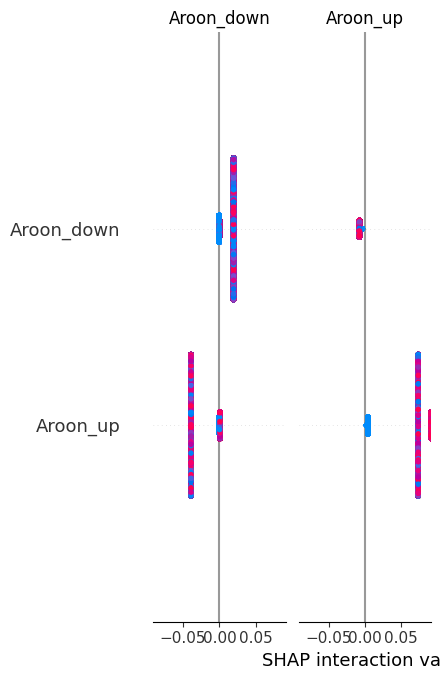

In [101]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model_chosen.named_steps['classifier'])
x_shap = X_train[X_train.columns.difference(['Name'])][first_train_fold_left:first_train_fold_right+1].astype(np.float64)
shap_values = explainer.shap_values(x_shap)

# Summary plot
shap.summary_plot(shap_values, x_shap, plot_type="bar")

In [102]:
# Detailed plot for a single prediction
# shap.initjs()
# shap.plots.force(explainer, shap_values[0,:], X_train.iloc[0,1:])

### 4. Pair Plot

A pair plot can help visualize the relationships between pairs of features and the target variable.

In [103]:
pair_plot_4_important_features_file = os.path.join(results_dir, 'pair_plot_4_important_features.png')
df_to_plot = X_train[top_features_base[:4]].copy()
df_to_plot['target'] = y_train
facet_grid = sns.pairplot(df_to_plot, hue='target')
plt.close()
facet_grid.figure.savefig(pair_plot_4_important_features_file)
print('plot of pair plot of 4 important features are saved into ', paint(pair_plot_4_important_features_file, format))


plot of pair plot of 4 important features are saved into  ../results/pair_plot_4_important_features.png


## Train model on the best features

### Create models

Create models, that use KBinsDiscretizer with 3 and 4 bins and models without transformers. The latter models will be used with the changed set. The changes are:
- transforme using the selected transformer
- extract only the best features. 

In [104]:
# create column transformer with KBinsDiscretizer with different number of bins (3 and 4)
kbins_quantile = KBinsDiscretizer(n_bins=10, strategy='quantile')
column_transformer_3 = NamedTransformer(name='target_std_quantile_power_kbins_q_3', 
                                      transformer=EncoderNameScalerDigitCols(
                                          transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                                (power_transformer, power_transformer_cols), 
                                                                (KBinsDiscretizer(n_bins=3, strategy='quantile'), kbins_discretizer_cols), 
                                                                (quantile_transformer, quantile_transformer_cols)], 
                                          encoder_columns=['Name'],
                                          encoder=target_encoder, 
                                          verbose_feature_names_out=False
                                     )).set_output(transform='pandas')
column_transformer_4 = NamedTransformer(name='target_std_quantile_power_kbins_q_4', 
                                      transformer=EncoderNameScalerDigitCols(
                                          transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                                (power_transformer, power_transformer_cols), 
                                                                (KBinsDiscretizer(n_bins=4, strategy='quantile'), kbins_discretizer_cols), 
                                                                (quantile_transformer, quantile_transformer_cols)], 
                                          encoder_columns=['Name'],
                                          encoder=target_encoder, 
                                          verbose_feature_names_out=False
                                     )).set_output(transform='pandas')

# create models to test different strategies of using information of important features
model_3_bins = Pipeline([   ('transformer', column_transformer_3),
                            ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_4_bins = Pipeline([   ('transformer', column_transformer_4),
                            ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_reduced = Pipeline([  ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_rfc = RandomForestClassifier(**model_params)

models_with_transformer = [('rf_3_bins', model_3_bins), 
                           ('rf_4_bins', model_4_bins)] 
models_no_transformer = [('rf_reduced', model_reduced), 
                         ('rf', model_rfc)]

### Fit the models

Fit models with transformers, that use less bins in KBinsDiscretizer (3 and 4 bins).

In [105]:
results_file = os.path.join(pkl_dir, 'scores_with_transformer.pkl')
scores_with_transformer = load_or_run(compare_scores_on_splits, results_file,
                                      **dict(model_tuples=models_with_transformer,
                                             cv=tscv_blocking_chosen,
                                             score_names=['accuracy', 'roc_auc', 'f1'],
                                             X=X_train, y=y_train)
                                     )

Loading results from ../results/pickled\scores_with_transformer.pkl


In [106]:
print(scores_with_transformer)
print('\n', paint('Mean:',format))
print(scores_with_transformer.mean())

       rf_3_bins                     rf_4_bins                    
        accuracy   roc_auc        f1  accuracy   roc_auc        f1
splits                                                            
0       0.480214  0.558499  0.618156   0.47989  0.559628  0.617918
1       0.464162   0.53067  0.601526  0.463758  0.530597  0.601967
2       0.555287  0.524889  0.661552  0.553835   0.52472  0.658012
3       0.529075  0.522869  0.639189  0.530607  0.523917   0.65464
4       0.519339  0.514396  0.675692  0.521193  0.514834  0.674981
5       0.536258  0.554171  0.695229  0.537223  0.554671   0.69509
6       0.552676  0.549342  0.706887  0.551791  0.546895  0.706292
7       0.484177  0.488074  0.646832  0.483775  0.487589   0.64611
8       0.514297  0.545063  0.675608  0.514538  0.544577  0.675925
9       0.523936  0.498555  0.676456   0.52498  0.497662  0.678342
10      0.513735  0.507327  0.673604  0.512932  0.506722  0.673908

 Mean:
rf_3_bins  accuracy    0.515741
           roc_auc    

Fit 2 models - with and without the demention reducer - on the set that comprises only the best features.

In [107]:
results_file = os.path.join(pkl_dir, 'scores_no_transformer.pkl')
scores_no_transformer = load_or_run(compare_scores_on_splits, results_file,
                                    **dict(model_tuples=models_no_transformer,
                                           cv=tscv_blocking_chosen,
                                           score_names=['accuracy', 'roc_auc', 'f1'],
                                           X=column_transformers_rf.fit_transform(X_train)[top_features],
                                           y=y_train
                                          ) 
                                    )


c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


Loading results from ../results/pickled\scores_no_transformer.pkl


In [108]:
print(scores_no_transformer)
print('\n', paint('Mean:',format))
print(scores_no_transformer.mean())

       rf_reduced                            rf                    
         accuracy   roc_auc        f1  accuracy   roc_auc        f1
splits                                                             
0        0.474873  0.564869  0.621301  0.474873  0.550901  0.624196
1        0.458747  0.521785  0.601878  0.473051  0.536091  0.601868
2        0.561497  0.526937  0.671262  0.505686  0.520154  0.540176
3        0.526091  0.522461  0.634713  0.528833  0.511911  0.659676
4        0.519098  0.510273  0.673523   0.51805  0.515883  0.648363
5        0.536821   0.56013  0.692197  0.539879    0.5675  0.660652
6        0.550905  0.543149  0.694982  0.532475  0.513684  0.663188
7        0.485944   0.48855  0.648815  0.481687  0.478029  0.622742
8         0.51494  0.542438  0.675584  0.518394  0.535479  0.650216
9        0.524337   0.50056  0.673935  0.513815  0.485472  0.623499
10        0.51261   0.51247  0.673658  0.522249  0.520891  0.640343

 Mean:
rf_reduced  accuracy    0.515078
       

### Compare the scores

In [109]:
df1 = scores_with_transformer.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df2 = scores_no_transformer.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df2[32:35]

,splits,model,score,score values
32,10,rf_reduced,f1,0.673658
33,0,rf,accuracy,0.474873
34,1,rf,accuracy,0.473051


In [110]:
data_to_plot = pd.concat([df1, df2], axis=0, ignore_index=True)
data_to_plot[64:67]

,splits,model,score,score values
64,9,rf_4_bins,f1,0.678342
65,10,rf_4_bins,f1,0.673908
66,0,rf_reduced,accuracy,0.474873


<Axes: title={'center': 'Compare models with and without transformer on splits'}, xlabel='splits', ylabel='score values'>

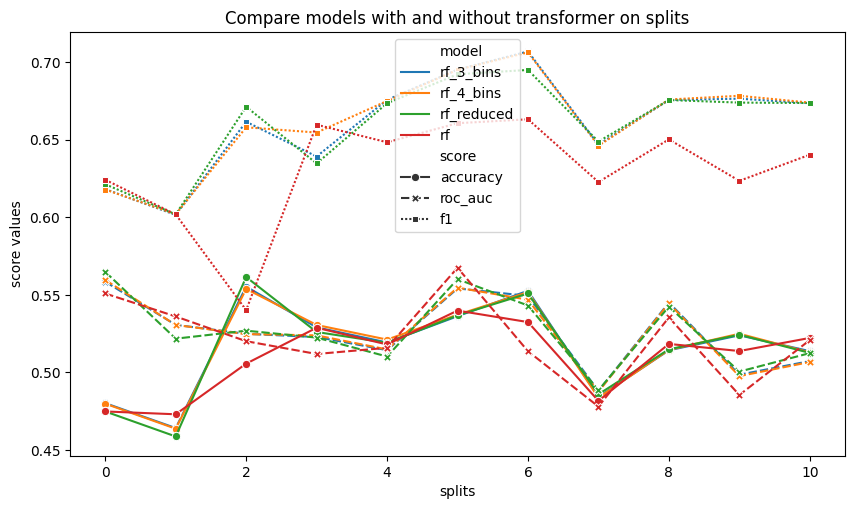

In [111]:
fig = plt.figure(figsize=(10, 5.5))
plt.title('Compare models with and without transformer on splits')
sns.lineplot(data=data_to_plot, x='splits', y='score values', style='score', hue='model', markers=True, dashes=True, legend='brief')

Models with fewer bins look a bit better than the models which are trained only on the top features. Reducers help more than cutting off the number of bins. 

### Create and fit the 'mix' model

Create a model with 5 bins to use on the set that comprises only the best features, it let train the model on the best features and use all Aroon values, not only "the best" bins. 

Create a transformer for the model.

In [112]:
def intercept_with_top_feature_base(lst:list) -> list:
    return list(set(lst) & set(top_features_base))

In [113]:
column_transformer_5_best_features = NamedTransformer(name='target_std_quantile_power_kbins_q_5_best_features', 
                                      transformer=EncoderNameScalerDigitCols(
                                          transformers_columns=[(std_scaler,intercept_with_top_feature_base(standard_scaling_cols)), 
                                                                (power_transformer, intercept_with_top_feature_base(power_transformer_cols)), 
                                                                (KBinsDiscretizer(n_bins=5, strategy='quantile'), intercept_with_top_feature_base(kbins_discretizer_cols)), 
                                                                (quantile_transformer, intercept_with_top_feature_base(quantile_transformer_cols))], 
                                          encoder_columns=['Name'],
                                          encoder=target_encoder, 
                                          verbose_feature_names_out=False
                                     )).set_output(transform='pandas')

Build and fit the Pipeline.

In [114]:

model_best_features = Pipeline([('transformer', column_transformer_5_best_features),
                                ('reduce_dim', FastICA(**reducer_params)),
                                ('classifier', RandomForestClassifier(**model_params))])


results_file = os.path.join(pkl_dir, 'scores_with_transformer_best_features.pkl')
scores_with_transformer_best_features = load_or_run(compare_scores_on_splits, results_file,
                                                    **dict(model_tuples=('rf_5_bins_best', model_best_features),
                                                           cv=tscv_blocking_chosen,
                                                           score_names=['accuracy', 'roc_auc', 'f1'],
                                                           X=X_train[list(top_features_base)+['Name']],
                                                           y=y_train
                                                      )
                                        )

Loading results from ../results/pickled\scores_with_transformer_best_features.pkl


In [115]:
print(scores_with_transformer_best_features)
print('\n', paint('Mean:',format))
print(scores_with_transformer_best_features.mean())

       rf_5_bins_best                    
             accuracy   roc_auc        f1
splits                                   
0            0.477219  0.557954  0.619732
1            0.456808  0.523714  0.601021
2            0.563594  0.524826  0.674252
3            0.531333  0.523615  0.652681
4            0.519903  0.510715  0.677248
5            0.538189  0.558923  0.692101
6            0.552193  0.544864  0.703412
7            0.484337  0.488969  0.649563
8            0.516305  0.543359  0.677899
9            0.525301  0.498624  0.681058
10           0.513333  0.511069  0.676111

 Mean:
rf_5_bins_best  accuracy    0.516229
                roc_auc     0.526057
                f1          0.664098
dtype: object


### Compare the scores of *3-bins* models to the Selected Model

In [161]:
results_file = os.path.join(pkl_dir, 'scores_compare_selected.pkl') 
scores_compare_selected = load_or_run(compare_scores_on_splits, results_file,  
                                      **dict(model_tuples=[('rf_10_bins', model_chosen)],
                                             cv=tscv_blocking_chosen,
                                             score_names=['accuracy', 'roc_auc', 'f1'],
                                             X=X_train, y=y_train
                                            )
)

Running compare_scores_on_splits and saving results to ../results/pickled\scores_compare_selected.pkl
Comparing scores on splits with 1 models: "rf_10_bins".

fit the models on 281173 samples .
fit the models on 281489 samples .
fit the models on 281814 samples .
fit the models on 282163 samples .
fit the models on 282506 samples .
fit the models on 282841 samples .
fit the models on 283191 samples .
fit the models on 283541 samples .
fit the models on 283895 samples .
fit the models on 284224 samples .
fit the models on 284539 samples .

<Axes: title={'center': 'Compare models with different number of bins and with best features on splits'}, xlabel='splits', ylabel='score values'>

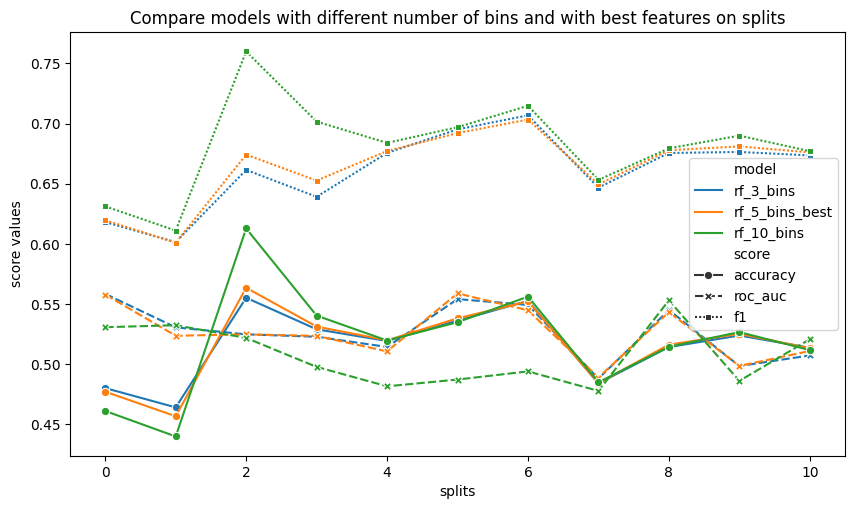

In [162]:
df1 = scores_with_transformer.loc[:,('rf_3_bins', slice(None))].melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df2 = scores_with_transformer_best_features.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df3 = scores_compare_selected.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
data_to_plot = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

fig = plt.figure(figsize=(10, 5.5))
plt.title('Compare models with different number of bins and with best features on splits')
sns.lineplot(data=data_to_plot, x='splits', y='score values', style='score', hue='model', markers=True, dashes=True, legend='brief')

Reducers help more than cutting off the number of bins. 

## Hyperparameters optimization

### 1

#### Classifiers and hyperparameters.

In [117]:
def create_transformer(encoder:str|None=None, power:bool=False, quantile:bool=False, kbins:str|None=None):
    transformers = []
    transformer_name = ''
    if isinstance(encoder, str):
        transformer_name += encoder
        if encoder== 'target':
            transformers.append(('name_encoder', target_encoder, ['Name']))
        elif encoder == 'ordinal':
            transformers.append(('name_encoder', ordinal_encoder, ['Name']))
        elif encoder == 'drop':
            transformers.append(('name_encoder', 'drop', ['Name']))
    else:
        transformer_name = 'no_encoder'
    
    if power:
        transformers.append(('power', power_transformer, power_transformer_cols))
        transformer_name += '_power'

    if quantile:
        transformers.append(('quantile', quantile_transformer, standard_scaling_cols+quantile_transformer_cols))
        transformer_name += '_quantile'

    if isinstance(kbins, str):
        if kbins[0] == 'u':
            if '20' in kbins:
                transformers.append(('kbinsu20', kbins_uniform_20, kbins_discretizer_cols))
                transformer_name += '_kbinsu20'
            else:
                transformers.append(('kbinsu10', kbins_uniform, kbins_discretizer_cols))
                transformer_name += '_kbinsu10'
        elif kbins[0] == 'q':
            if '20' in kbins:
                transformers.append(('kbinsq20', kbins_quantile_20, kbins_discretizer_cols))
                transformer_name += '_kbinsq20'
            else:
                transformers.append(('kbinsq10', kbins_quantile, kbins_discretizer_cols))
                transformer_name += '_kbinsq10'
        else:
            raise ValueError(f"Unknown KBinsDiscretizer type: {kbins}")
    return NamedTransformer(name=transformer_name, 
                            transformer=ColumnTransformer(
                                            transformers=transformers,
                                            remainder='passthrough',
                                            verbose_feature_names_out=False
                                        )
           ).set_output(transform='pandas')        

In [118]:
configer_classifier_rf_t_r=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators':[100],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': range(3,13,3), 
            'max_features': [None],  # 'sqrt' is default
            'max_depth': [2, 3, 4, 7, 10],
        }
    },
]

column_transformers_rf_t_r = [column_transformers['target_robust_not_indicators'],
                              column_transformers['target_quantile_power_kbins_u'],
                              create_transformer(encoder='target', power=True, quantile=True, kbins='q20'),
                              create_transformer(encoder='target', kbins='u'),
                              create_transformer(encoder='target', kbins='q20'),
                              create_transformer(encoder='target'),
]

# there are 23 features
dim_reducers_rf_t_r =[{'model': FastICA(), 'params': {'n_components': [1, 2, 4, 10, 19, 21, 22]}}, 
                      {'model': 'passthrough', 'params':{}}]


#### GridSearch

In [119]:
results_file_rf_t_r= os.path.join(pkl_dir,'gridsearch_results_rf_t_r.pkl' )
grid_search_results_rf_t_r = train_classifiers(results_file=results_file_rf_t_r,
                                         classifiers=configer_classifier_rf_t_r,
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking_chosen,
                                         column_transformers=column_transformers_rf_t_r,
                                         configed_dim_reducers=dim_reducers_rf_t_r,
                                         train_set_lengths=None, 
)

load trained models from ../results/pickled\gridsearch_results_rf_t_r.pkl
Model randomforestclassifier:
With parameters: [{'randomforestclassifier__n_estimators': [100], 'randomforestclassifier__min_samples_leaf': range(3, 13, 3), 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [2, 3, 4, 7, 10], 'transformer': [target_robust_not_indicators, target_quantile_power_kbins_u, target_power_quantile_kbinsq20, target_kbinsu10, target_kbinsq20, target], 'reduce_dim': [FastICA()], 'reduce_dim__n_components': [1, 2, 4, 10, 19, 21, 22]}, {'randomforestclassifier__n_estimators': [100], 'randomforestclassifier__min_samples_leaf': range(3, 13, 3), 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [2, 3, 4, 7, 10], 'transformer': [target_robust_not_indicators, target_quantile_power_kbins_u, target_power_quantile_kbinsq20, target_kbinsu10, target_kbinsq20, target], 'reduce_dim': ['passthrough']}]

Best parameters: {'randomforestcla

In [120]:
hyperparameters_file_best= os.path.join(pkl_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    for grid_search_result in grid_search_results_rf_t_r:
        f.write(f"{grid_search_result['name']}:\n")
        f.write(f"Best parameters: {grid_search_result['grid_search'].best_params_}\n")
        f.write(f"Best score: {grid_search_result['grid_search'].best_score_}\n")
        f.write(f"Grid serach time: {grid_search_result['search_time']/60} minutes")

#### Analyze results

In [121]:
save_grid_search_key_results(grid_search_results_rf_t_r, "Hyperparameters optimization: 1")
save_scores_of_stage_to_file(grid_search_results_rf_t_r, "Hyperparameters optimization: 1")

--- data is saved to ../results/key_results.md ---
randomforestclassifier
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [122]:
comparation_table = create_comparation_table([grid_search_results_rf, grid_search_results_rf_t_r],
                          ['RFC', 'RFC_trsf_redc'],
                          ['randomforestclassifier',], 
                          ['score', ])
comparation_table#[comparation_table['diff'] != 'Same']

RFC  \
model                  param                                             
randomforestclassifier max_depth_best                                3   
                       max_depth_grid                        [3, 4, 5]   
                       max_features_best                          None   
                       max_features_grid                        [None]   
                       min_samples_leaf_best                         3   
                       min_samples_leaf_grid                 [3, 5, 6]   
                       n_estimators_best                           200   
                       n_estimators_grid               [200, 250, 300]   
                       score                                  0.530081   
                       train_length_best                        280210   
                       train_length_grid      [265602, 280210, 300462]   

                                                 RFC_trsf_redc       diff  
model                  param                                               
randomforestclassifier max_depth_best                        2         --  
                       max_depth_grid         [2, 3, 4, 7, 10]         --  
                       max_features_best                  None       Same  
                       max_features_grid                [None]       Same  
                       min_samples_leaf_best                 9         --  
                       min_samples_leaf_grid   range(3, 13, 3)         --  
                       n_estimators_best                   100         --  
                       n_estimators_grid                 [100]         --  
                       score                           0.52257  Best: RFC  
                       train_length_best                   NaN         --  
                       train_length_grid                   NaN         --

In [123]:
training_params = ['max_depth', 'min_samples_leaf', 'reduce_dim', 'reduce_dim__n_components', 'transformer']
comparations, best_params  = create_train_test_comparation_tables(grid_search_results_rf_t_r, training_params)
titles = [f'Best {param_name}: {best_value}' for param_name, best_value in best_params.items()]
display_df_side_by_side(comparations.values(), titles)

,score,train,test,Model name
2,roc_auc,0.542740,0.522570,randomforestclassifier
3,roc_auc,0.561361,0.519012,randomforestclassifier
4,roc_auc,0.589210,0.518741,randomforestclassifier
7,roc_auc,0.711878,0.521470,randomforestclassifier
10,roc_auc,0.864464,0.513671,randomforestclassifier
2,accuracy,0.525338,0.513636,randomforestclassifier
3,accuracy,0.536198,0.509364,randomforestclassifier
4,accuracy,0.553189,0.513273,randomforestclassifier
7,accuracy,0.630430,0.515636,randomforestclassifier
10,accuracy,0.756531,0.505455,randomforestclassifier


In [124]:
param_name = 'reducers'
training_params = ['reduce_dim', 'reduce_dim__n_components']
param_comparation, best_param = create_tables_of_scores_by_param(grid_search_results_rf_t_r, par_names=training_params, key=f'rocauc_by_{param_name}')
param_comparation_accuracy, _ = create_tables_of_scores_by_param(grid_search_results_rf_t_r, par_names=training_params, score='accuracy', key=f'accuracy_by_{param_name}')
param_comparation = pd.concat([param_comparation, param_comparation_accuracy], axis=0, keys=['roc_auc', 'accuracy']).reset_index(names=['score', *training_params]) 
param_comparation[param_name] = param_comparation['reduce_dim'].astype(str) + '_' + param_comparation['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
comparations[param_name] = param_comparation.set_index(param_name)
best_params[param_name] = best_param
comparations[param_name]

,score,reduce_dim,reduce_dim__n_components,train,test,Model name
reducers,,,,,,
FastICA()_1,roc_auc,FastICA(),1,0.528569,0.518491,randomforestclassifier
FastICA()_2,roc_auc,FastICA(),2,0.527136,0.517375,randomforestclassifier
FastICA()_4,roc_auc,FastICA(),4,0.533374,0.516885,randomforestclassifier
FastICA()_10,roc_auc,FastICA(),10,0.54274,0.52257,randomforestclassifier
FastICA()_19,roc_auc,FastICA(),19,0.552503,0.507178,randomforestclassifier
FastICA()_21,roc_auc,FastICA(),21,0.553499,0.505881,randomforestclassifier
FastICA()_22,roc_auc,FastICA(),22,0.552375,0.505406,randomforestclassifier
passthrough_-,roc_auc,passthrough,-,0.542632,0.511666,randomforestclassifier
FastICA()_1,accuracy,FastICA(),1,0.514651,0.510636,randomforestclassifier


In [125]:
rocauc_by_splits_rf_t_r_file = os.path.join(results_dir,'roc_auc_rf_t_r_1.pdf')
# plot by splits
data_to_plot = grid_search_results_rf_t_r[0][KEY_BEST_ESTIMATOR_SCORES].reset_index().melt(id_vars=['split', 'set'], value_vars=['roc_auc', 'accuracy'], var_name='score_kind', value_name='score')
snsplot_split = lineplot(data_to_plot, x='split',  y='score', style='set', hue='score_kind', title='Compare ROC_AUC of the best models', figsize=(11, 4)) 
comparations['transformer'].index = comparations['transformer'].index.map(
    lambda x: ''.join(re.findall(r'(?:_|\b).{3}|\d{1,2}', x))
)

snsplots = []
for param_name, comparation in comparations.items():   
    df_to_plot = comparation.reset_index(names=param_name)
    snsplots.append(plot_validation_by(df_to_plot, by=param_name, score_to_plot='ROC_AUC and accuracy', hue='score'))

with PdfPages(rocauc_by_splits_rf_t_r_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    for snsplot in snsplots:
        snsplot.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_rf_t_r_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf_t_r_1.pdf


### 2

#### Classifiers and hyperparameters.

In [126]:
configer_classifier_rf_t_r_2=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators':[100],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': [8, 9, 10, 15], 
            'max_features': [None],  # 'sqrt' is default
            'max_depth': [1, 2, 3],
        }
    },
]

column_transformers_rf_t_r_2 = [column_transformers['target_robust_not_indicators'],
                              column_transformers['target_quantile_power_kbins_u'],
                              create_transformer(encoder='target', power=True, quantile=True, kbins='q20'),
]

# there are 23 features
dim_reducers_rf_t_r_2 =[{'model': FastICA(), 'params': {'n_components': [2, 7, 9, 10, 12, 14, 16]}}, 
                     ]


#### GridSearch

In [127]:
results_file_rf_t_r_2= os.path.join(pkl_dir,'gridsearch_results_rf_t_r_2.pkl' )
grid_search_results_rf_t_r_2 = train_classifiers(results_file=results_file_rf_t_r_2,
                                         classifiers=configer_classifier_rf_t_r_2,
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking_chosen,
                                         column_transformers=column_transformers_rf_t_r_2,
                                         configed_dim_reducers=dim_reducers_rf_t_r_2,
                                         train_set_lengths=None, 
)

load trained models from ../results/pickled\gridsearch_results_rf_t_r_2.pkl
Model randomforestclassifier:
With parameters: [{'randomforestclassifier__n_estimators': [100], 'randomforestclassifier__min_samples_leaf': [8, 9, 10, 15], 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [1, 2, 3], 'transformer': [target_robust_not_indicators, target_quantile_power_kbins_u, target_power_quantile_kbinsq20], 'reduce_dim': [FastICA()], 'reduce_dim__n_components': [2, 7, 9, 10, 12, 14, 16]}]

Best parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__n_estimators': 100, 'reduce_dim': FastICA(), 'reduce_dim__n_components': 14, 'transformer': target_quantile_power_kbins_u}
Best scores: 0.5253789534120157
Search time: 130.92294571333332 minutes


In [128]:
hyperparameters_file_best= os.path.join(pkl_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    for grid_search_result in grid_search_results_rf_t_r_2:
        f.write(f"{grid_search_result['name']}:\n")
        f.write(f"Best parameters: {grid_search_result['grid_search'].best_params_}\n")
        f.write(f"Best score: {grid_search_result['grid_search'].best_score_}\n")
        f.write(f"Grid serach time: {grid_search_result['search_time']/60} minutes")

#### Analyze results

In [129]:
save_grid_search_key_results(grid_search_results_rf_t_r_2, "Hyperparameters optimization: 2")
save_scores_of_stage_to_file(grid_search_results_rf_t_r_2, "Hyperparameters optimization: 2")

--- data is saved to ../results/key_results.md ---
randomforestclassifier
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [130]:
comparation_table = create_comparation_table([grid_search_results_rf_t_r, grid_search_results_rf_t_r_2],
                          ['1', '2'],
                          ['randomforestclassifier',], 
                          ['score', 'transformer', 'reduce_dim',])
comparation_table#[comparation_table['diff'] != 'Same']

1  \
model                  param                                                                      
randomforestclassifier max_depth_best                                                         2   
                       max_depth_grid                                          [2, 3, 4, 7, 10]   
                       max_features_best                                                   None   
                       max_features_grid                                                 [None]   
                       min_samples_leaf_best                                                  9   
                       min_samples_leaf_grid                                    range(3, 13, 3)   
                       n_components_best                                                     10   
                       n_components_grid                              [1, 2, 4, 10, 19, 21, 22]   
                       n_estimators_best                                                    100   
                       n_estimators_grid                                                  [100]   
                       reduce_dim_best                                                FastICA()   
                       reduce_dim_grid                               [FastICA(), 'passthrough']   
                       score                                                            0.52257   
                       transformer_best                           target_quantile_power_kbins_u   
                       transformer_grid       [target_robust_not_indicators, target_quantile...   

                                                                                              2  \
model                  param                                                                      
randomforestclassifier max_depth_best                                                         3   
                       max_depth_grid                                                 [1, 2, 3]   
                       max_features_best                                                   None   
                       max_features_grid                                                 [None]   
                       min_samples_leaf_best                                                 15   
                       min_samples_leaf_grid                                     [8, 9, 10, 15]   
                       n_components_best                                                     14   
                       n_components_grid                              [2, 7, 9, 10, 12, 14, 16]   
                       n_estimators_best                                                    100   
                       n_estimators_grid                                                  [100]   
                       reduce_dim_best                                                FastICA()   
                       reduce_dim_grid                                              [FastICA()]   
                       score                                                           0.525379   
                       transformer_best                           target_quantile_power_kbins_u   
                       transformer_grid       [target_robust_not_indicators, target_quantile...   

                                                 diff  
model                  param                           
randomforestclassifier max_depth_best              --  
                       max_depth_grid              --  
                       max_features_best         Same  
                       max_features_grid         Same  
                       min_samples_leaf_best       --  
                       min_samples_leaf_grid       --  
                       n_components_best           --  
                       n_components_grid           --  
                       n_estimators_best         Same  
                       n_estimators_grid         Same  
                       reduce_dim_best           Same 

In [131]:
training_params = ['max_depth', 'min_samples_leaf', 'reduce_dim', 'reduce_dim__n_components', 'transformer']
comparations, best_params  = create_train_test_comparation_tables(grid_search_results_rf_t_r_2, training_params)
titles = [f'Best {param_name}: {best_value}' for param_name, best_value in best_params.items()]
display_df_side_by_side(comparations.values(), titles)

,score,train,test,Model name
1,roc_auc,0.533338,0.507989,randomforestclassifier
2,roc_auc,0.549960,0.514953,randomforestclassifier
3,roc_auc,0.568236,0.525379,randomforestclassifier
1,accuracy,0.517958,0.515000,randomforestclassifier
2,accuracy,0.527017,0.512364,randomforestclassifier
3,accuracy,0.537303,0.518545,randomforestclassifier
,score,train,test,Model name
8,roc_auc,0.570859,0.514977,randomforestclassifier
9,roc_auc,0.569968,0.519232,randomforestclassifier
10,roc_auc,0.569242,0.516209,randomforestclassifier


In [132]:
param_name = 'reducers'
training_params = ['reduce_dim', 'reduce_dim__n_components']
param_comparation, best_param = create_tables_of_scores_by_param(grid_search_results_rf_t_r_2, par_names=training_params, key=f'rocauc_by_{param_name}')
param_comparation_accuracy, _ = create_tables_of_scores_by_param(grid_search_results_rf_t_r_2, par_names=training_params, score='accuracy', key=f'accuracy_by_{param_name}')
param_comparation = pd.concat([param_comparation, param_comparation_accuracy], axis=0, keys=['roc_auc', 'accuracy']).reset_index(names=['score', *training_params]) 
param_comparation[param_name] = param_comparation['reduce_dim'].astype(str) + '_' + param_comparation['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
comparations[param_name] = param_comparation.set_index(param_name)
best_params[param_name] = best_param
comparations[param_name]

,score,reduce_dim,reduce_dim__n_components,train,test,Model name
reducers,,,,,,
FastICA()_2,roc_auc,FastICA(),2,0.540425,0.510846,randomforestclassifier
FastICA()_7,roc_auc,FastICA(),7,0.557811,0.514156,randomforestclassifier
FastICA()_9,roc_auc,FastICA(),9,0.560652,0.510798,randomforestclassifier
FastICA()_10,roc_auc,FastICA(),10,0.562042,0.512516,randomforestclassifier
FastICA()_12,roc_auc,FastICA(),12,0.564052,0.512275,randomforestclassifier
FastICA()_14,roc_auc,FastICA(),14,0.568236,0.525379,randomforestclassifier
FastICA()_16,roc_auc,FastICA(),16,0.570408,0.515923,randomforestclassifier
FastICA()_2,accuracy,FastICA(),2,0.524159,0.507364,randomforestclassifier
FastICA()_7,accuracy,FastICA(),7,0.534653,0.503545,randomforestclassifier


In [133]:
rocauc_by_splits_rf_t_r_file = os.path.join(results_dir,'roc_auc_rf_t_r_2.pdf')
# plot by splits
data_to_plot = grid_search_results_rf_t_r_2[0][KEY_BEST_ESTIMATOR_SCORES].reset_index().melt(id_vars=['split', 'set'], value_vars=['roc_auc', 'accuracy'], var_name='score_kind', value_name='score')
snsplot_split = lineplot(data_to_plot, x='split',  y='score', style='set', hue='score_kind', title='Compare ROC_AUC of the best models', figsize=(11, 4)) 
comparations['transformer'].index = comparations['transformer'].index.map(
    lambda x: ''.join(re.findall(r'(?:_|\b).{3}|\d{1,2}', x))
)

snsplots = []
for param_name, comparation in comparations.items():   
    df_to_plot = comparation.reset_index(names=param_name)
    snsplots.append(plot_validation_by(df_to_plot, by=param_name, score_to_plot='ROC_AUC and accuracy', hue='score'))

with PdfPages(rocauc_by_splits_rf_t_r_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    for snsplot in snsplots:
        snsplot.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_rf_t_r_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf_t_r_2.pdf


### 3

#### Classifiers and hyperparameters.

In [134]:
configer_classifier_rf_t_r_3=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators':[100],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': [10, 12, 15, 18, 20], 
            'max_features': [None],  # 'sqrt' is default
            'max_depth': [1, 2, 3, 4],
        }
    },
]

column_transformers_rf_t_r_3 = [column_transformers['target_quantile_power_kbins_u'],
                                # create_transformer(encoder='target', power=True, quantile=True, kbins='q20'),
]

# there are 23 features
dim_reducers_rf_t_r_3 =[{'model': FastICA(), 'params': {'n_components': [1, 9, 10, 11, 12, 13, 14, 15]}}, 
                     ]


#### GridSearch

In [135]:
results_file_rf_t_r_3= os.path.join(pkl_dir,'gridsearch_results_rf_t_r_3.pkl' )
grid_search_results_rf_t_r_3 = train_classifiers(results_file=results_file_rf_t_r_3,
                                         classifiers=configer_classifier_rf_t_r_3,
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking_chosen,
                                         column_transformers=column_transformers_rf_t_r_3,
                                         configed_dim_reducers=dim_reducers_rf_t_r_3,
                                         train_set_lengths=None, 
)

Run grid search on randomforestclassifier classifier
With parameters: {'n_estimators': [100], 'min_samples_leaf': [10, 12, 15, 18, 20], 'max_features': [None], 'max_depth': [1, 2, 3, 4]}
For train set lengths: None
Fitting 11 folds for each of 160 candidates, totalling 1760 fits
-----------------------------------------------------
Grid search took 107.46182514833441 minutes
Best parameters: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 12, 'randomforestclassifier__n_estimators': 100, 'reduce_dim': FastICA(), 'reduce_dim__n_components': 13, 'transformer': target_quantile_power_kbins_u}
Best scores: 0.5301448643387604


#### Analyze results

In [136]:
save_grid_search_key_results(grid_search_results_rf_t_r_3, "Hyperparameters optimization: 3")
save_scores_of_stage_to_file(grid_search_results_rf_t_r_3, "Hyperparameters optimization: 3")

--- data is saved to ../results/key_results.md ---
randomforestclassifier
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [137]:
comparation_table = create_comparation_table([grid_search_results_rf_t_r, grid_search_results_rf_t_r_2,  grid_search_results_rf_t_r_3],
                          ['1', '2', '3'],
                          ['randomforestclassifier',], 
                          ['score', 'transformer', 'reduce_dim',])
comparation_table#[comparation_table['diff'] != 'Same']

1  \
model                  param                                                                      
randomforestclassifier max_depth_best                                                         2   
                       max_depth_grid                                          [2, 3, 4, 7, 10]   
                       max_features_best                                                   None   
                       max_features_grid                                                 [None]   
                       min_samples_leaf_best                                                  9   
                       min_samples_leaf_grid                                    range(3, 13, 3)   
                       n_components_best                                                     10   
                       n_components_grid                              [1, 2, 4, 10, 19, 21, 22]   
                       n_estimators_best                                                    100   
                       n_estimators_grid                                                  [100]   
                       reduce_dim_best                                                FastICA()   
                       reduce_dim_grid                               [FastICA(), 'passthrough']   
                       score                                                            0.52257   
                       transformer_best                           target_quantile_power_kbins_u   
                       transformer_grid       [target_robust_not_indicators, target_quantile...   

                                                                                              2  \
model                  param                                                                      
randomforestclassifier max_depth_best                                                         3   
                       max_depth_grid                                                 [1, 2, 3]   
                       max_features_best                                                   None   
                       max_features_grid                                                 [None]   
                       min_samples_leaf_best                                                 15   
                       min_samples_leaf_grid                                     [8, 9, 10, 15]   
                       n_components_best                                                     14   
                       n_components_grid                              [2, 7, 9, 10, 12, 14, 16]   
                       n_estimators_best                                                    100   
                       n_estimators_grid                                                  [100]   
                       reduce_dim_best                                                FastICA()   
                       reduce_dim_grid                                              [FastICA()]   
                       score                                                           0.525379   
                       transformer_best                           target_quantile_power_kbins_u   
                       transformer_grid       [target_robust_not_indicators, target_quantile...   

                                                                            3  \
model                  param                                                    
randomforestclassifier max_depth_best                                       1   
                       max_depth_grid                            [1, 2, 3, 4]   
                       max_features_best                                 None   
                       max_features_grid                               [None]   
                       min_samples_leaf_best                               12   
                       min_samples_leaf_grid             [10, 12, 15, 18, 20]   
                       n_components_best                                   13 

In [138]:
training_params = ['max_depth', 'min_samples_leaf', 'reduce_dim', 'reduce_dim__n_components', 'transformer']
comparations, best_params  = create_train_test_comparation_tables(grid_search_results_rf_t_r_3, training_params)
titles = [f'Best {param_name}: {best_value}' for param_name, best_value in best_params.items()]
display_df_side_by_side(comparations.values(), titles)

,score,train,test,Model name
1,roc_auc,0.532638,0.530145,randomforestclassifier
2,roc_auc,0.547020,0.525256,randomforestclassifier
3,roc_auc,0.567036,0.517639,randomforestclassifier
4,roc_auc,0.595503,0.519157,randomforestclassifier
1,accuracy,0.515508,0.510364,randomforestclassifier
2,accuracy,0.526569,0.511455,randomforestclassifier
3,accuracy,0.538805,0.505909,randomforestclassifier
4,accuracy,0.558135,0.506182,randomforestclassifier
,score,train,test,Model name
10,roc_auc,0.533045,0.522919,randomforestclassifier


In [139]:
param_name = 'reducers'
training_params = ['reduce_dim', 'reduce_dim__n_components']
param_comparation, best_param = create_tables_of_scores_by_param(grid_search_results_rf_t_r_3, par_names=training_params, key=f'rocauc_by_{param_name}')
param_comparation_accuracy, _ = create_tables_of_scores_by_param(grid_search_results_rf_t_r_3, par_names=training_params, score='accuracy', key=f'accuracy_by_{param_name}')
param_comparation = pd.concat([param_comparation, param_comparation_accuracy], axis=0, keys=['roc_auc', 'accuracy']).reset_index(names=['score', *training_params]) 
param_comparation[param_name] = param_comparation['reduce_dim'].astype(str) + '_' + param_comparation['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
comparations[param_name] = param_comparation.set_index(param_name)
best_params[param_name] = best_param
comparations[param_name]

,score,reduce_dim,reduce_dim__n_components,train,test,Model name
reducers,,,,,,
FastICA()_1,roc_auc,FastICA(),1,0.513408,0.52668,randomforestclassifier
FastICA()_9,roc_auc,FastICA(),9,0.528121,0.5212,randomforestclassifier
FastICA()_10,roc_auc,FastICA(),10,0.529368,0.52169,randomforestclassifier
FastICA()_11,roc_auc,FastICA(),11,0.528522,0.528405,randomforestclassifier
FastICA()_12,roc_auc,FastICA(),12,0.530195,0.52423,randomforestclassifier
FastICA()_13,roc_auc,FastICA(),13,0.532638,0.530145,randomforestclassifier
FastICA()_14,roc_auc,FastICA(),14,0.532074,0.511789,randomforestclassifier
FastICA()_15,roc_auc,FastICA(),15,0.531553,0.508569,randomforestclassifier
FastICA()_1,accuracy,FastICA(),1,0.512716,0.503818,randomforestclassifier


In [140]:
rocauc_by_splits_rf_t_r_file = os.path.join(results_dir,'roc_auc_rf_t_r_3.pdf')
# plot by splits
data_to_plot = grid_search_results_rf_t_r_3[0][KEY_BEST_ESTIMATOR_SCORES].reset_index().melt(id_vars=['split', 'set'], value_vars=['roc_auc', 'accuracy'], var_name='score_kind', value_name='score')
snsplot_split = lineplot(data_to_plot, x='split',  y='score', style='set', hue='score_kind', title='Compare ROC_AUC of the best models', figsize=(11, 4)) 
comparations['transformer'].index = comparations['transformer'].index.map(
    lambda x: ''.join(re.findall(r'(?:_|\b).{3}|\d{1,2}', x))
)

snsplots = []
for param_name, comparation in comparations.items():   
    df_to_plot = comparation.reset_index(names=param_name)
    snsplots.append(plot_validation_by(df_to_plot, by=param_name, score_to_plot='ROC_AUC and accuracy', hue='score'))

with PdfPages(rocauc_by_splits_rf_t_r_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    for snsplot in snsplots:
        snsplot.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_rf_t_r_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf_t_r_3.pdf


In [145]:
model_chosen = grid_search_results_rf_t_r_3[0]['grid_search'].best_estimator_

### Tune the threshold

In [156]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

results_file = os.path.join(pkl_dir, 'rfc_tuned.pkl')
rfc_tuned = load_or_run(
    TunedThresholdClassifierCV(
        model_chosen, cv = tscv_blocking_chosen, scoring="balanced_accuracy", store_cv_results=True, response_method="predict_proba"
    ).fit,
    results_file, X_train, y_train)

print(
    f"Cut-off point found at {rfc_tuned.best_threshold_:.3f}"
)
print(f'Best score: {rfc_tuned.best_score_}')
print(f'Best threshold: {rfc_tuned.best_threshold_}')

warnings.filterwarnings("default", category=UserWarning)


Running fit and saving results to ../results/pickled\rfc_tuned.pkl
Cut-off point found at 0.513
Best score: 0.508097168688224
Best threshold: 0.5127972385022269


#### Scores for the tuned models

In [157]:
from sklearn.model_selection import FixedThresholdClassifier
model_fixed_tuned = FixedThresholdClassifier(model_chosen, threshold=rfc_tuned.best_threshold_)
model_fixed_thrhd = FixedThresholdClassifier(model_chosen, threshold=0.523)

In [158]:
results_file = os.path.join(pkl_dir, 'scores_compare_tunned.pkl') 
scores_compare_tunned = load_or_run(compare_scores_on_splits, results_file,  
                                    **dict(model_tuples=[('rf', model_chosen), ('rf_tuned', model_fixed_tuned), ('thrhd=.523', model_fixed_thrhd)],
                                           cv=tscv_blocking_chosen,
                                           score_names=['accuracy', 'roc_auc', 'f1'],
                                           X=X_train, y=y_train)
)


Running compare_scores_on_splits and saving results to ../results/pickled\scores_compare_tunned.pkl
Comparing scores on splits with 3 models: "rf", "rf_tuned", "thrhd=.523".

fit the models on 281173 samples ...
fit the models on 281489 samples ...
fit the models on 281814 samples ...
fit the models on 282163 samples ...
fit the models on 282506 samples ...
fit the models on 282841 samples ...
fit the models on 283191 samples ...
fit the models on 283541 samples ...
fit the models on 283895 samples ...
fit the models on 284224 samples ...
fit the models on 284539 samples ...

In [159]:
print(scores_compare_tunned.rename(columns=lambda x: 'accur' if 'accur' in x else x, level=1).astype(float).round(3))
print('\n', paint('Mean:',format))
pd.DataFrame(scores_compare_tunned.mean()).T.astype(float).round(3)

           rf                rf_tuned                thrhd=.523               
        accur roc_auc     f1    accur roc_auc     f1      accur roc_auc     f1
splits                                                                        
0       0.461   0.538  0.631    0.540   0.544  0.484      0.547   0.544  0.370
1       0.440   0.522  0.611    0.529   0.536  0.406      0.536   0.537  0.380
2       0.613   0.525  0.760    0.455   0.516  0.380      0.426   0.518  0.235
3       0.540   0.503  0.702    0.485   0.497  0.416      0.474   0.502  0.183
4       0.520   0.485  0.684    0.501   0.495  0.540      0.478   0.481  0.304
5       0.535   0.500  0.697    0.505   0.501  0.481      0.457   0.496  0.252
6       0.556   0.511  0.715    0.496   0.504  0.508      0.450   0.497  0.087
7       0.485   0.500  0.653    0.480   0.478  0.624      0.496   0.479  0.072
8       0.515   0.546  0.679    0.533   0.546  0.440      0.515   0.552  0.316
9       0.527   0.492  0.690    0.477   0.486  0.359

rf                rf_tuned                thrhd=.523               
  accuracy roc_auc     f1 accuracy roc_auc     f1   accuracy roc_auc     f1
0    0.519   0.513  0.682    0.502   0.511  0.474      0.487   0.511  0.248

## Compare to the DummyClassifier

In [133]:
from sklearn.dummy import DummyClassifier
dummy_scores={"stratified":0, "most_frequent":0, "uniform":0}
for strategy in dummy_scores.keys():
    dummy_regr = DummyClassifier(strategy=strategy)
    dummy_regr.fit(X_train, y_train)
    print(f"Predictions: {dummy_regr.predict(X_train)[:10]}")
    print(f"Accuracy: {dummy_regr.score(X_train, y_train)}")

Predictions: [1 1 0 1 1 1 1 1 0 0]
Accuracy: 0.5016080203768342
Predictions: [1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.5186058677735564
Predictions: [0 1 1 1 1 0 1 1 0 1]
Accuracy: 0.5000235842988602


# Strategy backtesting

## Predict

### Create set of data

In [134]:
train_prediction_X = pd.concat([X_train, X_test])
train_prediction_y = pd.concat([y_train, y_test])
train_prediction_return = pd.concat([X_train_return, X_test_return])

### Train loop

In [136]:
results_file = os.path.join(pkl_dir, 'predictions_on_splits.pkl')
predictions_on_splits_results = load_or_run(predictions_on_splits, results_file,
                                            **dict(models=[model_chosen, model_fixed_thrhd, model_fixed_tuned],
                                                 cv=tscv_blocking_chosen,
                                                 X=train_prediction_X, 
                                                 y=train_prediction_y
                                            )
)

Loading results from ../results/pickled\predictions_on_splits.pkl


In [137]:
for i, model_txt in enumerate(["model", "fixed threshold model", "tunned threshold model"]):
    print(f'{model_txt} accuracy {accuracy_score(y_test, predictions_on_splits_results["predicted"][i])}')

model accuracy 0.5260766538403009
fixed threshold model accuracy 0.47495235403668196
tunned threshold model accuracy 0.502663101371769


In [138]:
probabilities = pd.concat([y_train, predictions_on_splits_results["predicted_probabilities"][0]])

## Create strategies

### Generate signal

In [139]:
def long_only_strategy(df_returns, probabilities, threshold=0.5, proportional=False):
    res = df_returns.copy()
    res['Probabilities'] = probabilities
    res['Signal'] = res['Probabilities'].apply(lambda x: 1 if x > threshold else 0)
    # if there is no invest on all stock on a day, invest $1 on the best stock
    def _best_stock(x):
        return (x['return'] == x['return'].max()).astype(int)
    res['Signal'] = res.groupby('date').apply(lambda df: _best_stock(df) if df['Signal'].sum()==0 else df['Signal']).reset_index(level=0, drop=True)
    if proportional:
        res['Signal'] = res['Probabilities'].where(res['Signal'].astype(bool), 0)
    res['Signal'] = res['Signal'].groupby('date').transform(lambda x: x/x.sum())
    res['Strategy_Return'] = res['Signal'] * res['return']
    return res

long_only_df = long_only_strategy(train_prediction_return, probabilities, 0.5)
long_only_prop_df = long_only_strategy(train_prediction_return, probabilities, 0.5, proportional=True)

In [140]:
def short_only_strategy(df_returns, probabilities, threshold=0.5, proportional=False):
    res = df_returns.copy()
    res['Probabilities'] = probabilities
    res['Signal'] = res['Probabilities'].apply(lambda x: 1 if x < threshold else 0)
    # if there is no invest on all stock on a day, invest $1 on the best stock
    def _worst_stock(x):
        return (x['return'] == x['return'].min()).astype(int)
    res['Signal'] = res.groupby('date').apply(lambda df: _worst_stock(df) if df['Signal'].sum()==0 else df['Signal']).reset_index(level=0, drop=True)
    if proportional:
        res['Signal'] = (1-res['Probabilities']).where(res['Signal'].astype(bool), 0)
    res['Signal'] = res['Signal'].groupby('date').transform(lambda x: x/x.sum())
    res['Strategy_Return'] = - res['Signal'] * res['return']
    return res

short_only_df = short_only_strategy(train_prediction_return, probabilities, 0.5)
short_only_prop_df = short_only_strategy(train_prediction_return, probabilities, 0.5, proportional=True)

In [141]:
def long_short_strategy(df_returns, probabilities, thresholds=0.5):
    res = df_returns.copy()
    res['Probabilities'] = probabilities
    if isinstance(thresholds, Iterable):
        res['Signal'] = res['Probabilities'].apply(lambda x: -1 if x < thresholds[0] else (1 if x > thresholds[1] else 0))
    else:
        res['Signal'] = res['Probabilities'].apply(lambda x: -1 if x < thresholds else 1)
    # if there is no invest on all stock on a day, invest $1 on the best stock
    def _stocks_on_edge(x):
        return -(x['return'] == x['return'].min()).astype(int) + (x['return'] == x['return'].max()).astype(int)
    res['Signal'] = res.groupby('date').apply(lambda df: _stocks_on_edge(df) if df['Signal'].abs().sum()==0 else df['Signal']).reset_index(level=0, drop=True)
    res['Signal'] = res['Signal'].groupby('date').transform(lambda x: x/x.abs().sum())
    res['Strategy_Return'] = res['Signal'] * res['return']
    return res

long_short_df = long_short_strategy(train_prediction_return, probabilities, 0.5)
long_short_2_thresholds_df = long_short_strategy(train_prediction_return, probabilities, [0.4, 0.6])

### Compare strategies' PnL

In [142]:
PnL = pd.DataFrame({'Long Only': long_only_df.groupby('date')['Strategy_Return'].sum(), 
                    'Long Only proportional': long_only_prop_df.groupby('date')['Strategy_Return'].sum(), 
                    'Short Only': short_only_df.groupby('date')['Strategy_Return'].sum(), 
                    'Short Only proportional': short_only_prop_df.groupby('date')['Strategy_Return'].sum(),
                    'Long Short': long_short_df.groupby('date')['Strategy_Return'].sum(),
                    'Long Short 2 thresholds': long_short_2_thresholds_df.groupby('date')['Strategy_Return'].sum(),
                    })
PnL['SP500'] = sp500_history.loc[PnL.index,'return']
for col in PnL.columns:
    PnL[f'{col} cumulative'] = PnL[col].cumsum()
PnL

,Long Only,Long Only proportional,Short Only,Short Only proportional,Long Short,Long Short 2 thresholds,SP500,Long Only cumulative,Long Only proportional cumulative,Short Only cumulative,Short Only proportional cumulative,Long Short cumulative,Long Short 2 thresholds cumulative,SP500 cumulative
date,,,,,,,,,,,,,,
2013-03-18,0.011550,0.011550,0.007115,0.007115,0.010926,0.010926,0.006697,0.011550,0.011550,0.007115,0.007115,0.010926,0.010926,0.006697
2013-03-19,0.005723,0.005723,0.011291,0.011291,0.010577,0.010577,-0.008282,0.017273,0.017273,0.018406,0.018406,0.021503,0.021503,-0.001585
2013-03-20,0.009188,0.009188,0.006056,0.006056,0.008458,0.008458,0.007174,0.026461,0.026461,0.024462,0.024462,0.029960,0.029960,0.005589
2013-03-21,0.005812,0.005812,0.007210,0.007210,0.006793,0.006793,-0.003340,0.032273,0.032273,0.031672,0.031672,0.036753,0.036753,0.002249
2013-03-22,0.010215,0.010215,0.004393,0.004393,0.009273,0.009273,0.007785,0.042488,0.042488,0.036065,0.036065,0.046027,0.046027,0.010034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-30,-0.002467,-0.002516,0.081106,0.081106,-0.002467,0.121158,-0.000648,9.854257,9.853650,21.957931,21.957301,10.706518,33.530505,0.620781
2018-01-31,-0.020129,-0.020133,0.076093,0.076093,-0.020129,0.077537,-0.021209,9.834128,9.833517,22.034024,22.033393,10.686389,33.608042,0.599572
2018-02-01,-0.036907,-0.036877,0.092243,0.092243,-0.036907,0.064608,-0.040979,9.797221,9.796640,22.126267,22.125636,10.649482,33.672650,0.558593


PnL for the test period

In [143]:
PnL[PnL.index>=X_test.index[0]]

,Long Only,Long Only proportional,Short Only,Short Only proportional,Long Short,Long Short 2 thresholds,SP500,Long Only cumulative,Long Only proportional cumulative,Short Only cumulative,Short Only proportional cumulative,Long Short cumulative,Long Short 2 thresholds cumulative,SP500 cumulative
date,,,,,,,,,,,,,,
2017-01-03,-0.003180,-0.003268,0.004196,0.004196,-0.003165,0.142602,-0.000771,9.664372,9.664285,9.288436,9.288436,10.516792,10.662559,0.400066
2017-01-04,0.003091,0.003092,0.058385,0.058385,0.003091,0.057461,0.003517,9.667464,9.667377,9.346821,9.346821,10.519883,10.720021,0.403583
2017-01-05,-0.005469,-0.005485,0.000525,0.000606,-0.005445,0.120593,-0.003549,9.661995,9.661892,9.347346,9.347427,10.514438,10.840614,0.400035
2017-01-06,0.001549,0.001590,-0.008608,-0.008608,0.001528,0.136727,0.000000,9.663543,9.663482,9.338737,9.338819,10.515967,10.977340,0.400035
2017-01-09,0.002794,0.002805,0.004267,0.004267,0.002797,0.056793,0.002830,9.666338,9.666287,9.343005,9.343086,10.518764,11.034133,0.402864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-30,-0.002467,-0.002516,0.081106,0.081106,-0.002467,0.121158,-0.000648,9.854257,9.853650,21.957931,21.957301,10.706518,33.530505,0.620781
2018-01-31,-0.020129,-0.020133,0.076093,0.076093,-0.020129,0.077537,-0.021209,9.834128,9.833517,22.034024,22.033393,10.686389,33.608042,0.599572
2018-02-01,-0.036907,-0.036877,0.092243,0.092243,-0.036907,0.064608,-0.040979,9.797221,9.796640,22.126267,22.125636,10.649482,33.672650,0.558593


In [144]:
last_train_date = X_train_return.index.max()
pnl_plot_file = os.path.join(results_dir, 'strategies_test_period.png')
cols_to_plot = [col for col in PnL.columns if 'cumulative' not in col and 'SP500' not in col]
data_to_plot = PnL[PnL.index>=X_test.index[0]].reset_index()#.melt(id_vars='date', value_vars=cols_to_plot, var_name='Strategy', value_name='Return')

title = 'Profit and Loss of the strategies by days'
fig, axs = get_fig_and_axes(1, len(cols_to_plot), fig_width=15)
fig.suptitle(title)
for i, col in enumerate(cols_to_plot):
    sns.lineplot(data=data_to_plot, x='date', y=col,  markers=True, dashes=True, legend='brief', ax=axs[i], label=col)
    sns.lineplot(data=data_to_plot, x='date', y='SP500', markers=True, dashes=True, legend='brief', ax=axs[i], label='SP500')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.close(fig)
fig.savefig(pnl_plot_file)
print(f'Profit and Loss plot saved to {paint(pnl_plot_file, format)}')

Profit and Loss plot saved to ../results/strategies_test_period.png


In [145]:
last_train_date = X_train_return.index.max()
pnl_plot_file = os.path.join(results_dir, 'strategies.png')
cols_to_plot = [col for col in PnL.columns if 'cumulative' not in col]
data_to_plot = PnL.reset_index().melt(id_vars='date', value_vars=cols_to_plot, var_name='Strategy', value_name='Return')

#snsplot = lineplot(data_to_plot, 'date', title='Profit and Loss of the strategies by days', score_to_plot='Return',style=None, hue='Strategy', figsize=(10, 6))
figsize = (10, 6)
title = 'Profit and Loss of the strategies by days'
plt.figure(figsize=figsize)
plt.title(title)
snsplot = sns.lineplot(data=data_to_plot, x='date', y='Return', style=None, hue='Strategy', markers=True, dashes=True, legend='brief')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
snsplot.plot([last_train_date, last_train_date], [PnL[cols_to_plot].min().min(), PnL[cols_to_plot].max().max()], 'r--')
snsplot.figure.tight_layout()
plt.close(snsplot.figure)
snsplot.figure.savefig(pnl_plot_file)
print(f'Profit and Loss plot saved to {paint(pnl_plot_file, format)}')

Profit and Loss plot saved to ../results/strategies.png


In [146]:
pnl_cumulative_plot_file = os.path.join(results_dir, 'strategies_cumulative_plot.png')
cols_to_plot = [col for col in PnL.columns if 'cumulative' in col]
data_to_plot = PnL.reset_index().melt(id_vars='date', value_vars=cols_to_plot, var_name='Strategy', value_name='Cumulative Return')

#snsplot = lineplot(data_to_plot, 'date', title='Cumulative Profit and Loss of the strategies by days', score_to_plot='Cumulative Return',style=None, hue='Strategy', figsize=(10, 6))
figsize = (10, 6)
title = 'Cumulative Profit and Loss of the strategies by days'
plt.figure(figsize=figsize)
plt.title(title)
snsplot = sns.lineplot(data=data_to_plot, x='date', y='Cumulative Return', style=None, hue='Strategy', markers=True, dashes=True, legend='brief')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
snsplot.plot([last_train_date, last_train_date], [PnL[cols_to_plot].min().min(), PnL[cols_to_plot].max().max()], 'r--')
plt.close(snsplot.figure)
snsplot.figure.savefig(pnl_cumulative_plot_file)
print(f'Cumulative Profit and Loss plot saved to {paint(pnl_cumulative_plot_file, format)}')

Cumulative Profit and Loss plot saved to ../results/strategies_cumulative_plot.png


In [147]:
cum_cols = [col for col in PnL.columns if 'cumulative' in col]
cummax = PnL[cum_cols].cummax()
drawdown = (cummax - PnL[cum_cols])*100/cummax #(PnL[cum_cols]-cummax)*100/cummax
max_drawdown = drawdown.min()

In [148]:
report_file = os.path.join(results_dir, 'report.md')
with open(report_file, 'w') as f:
    f.write(f'# Report\n')
    f.write(f'\n\n## Features used\n\n')
    f.write(pd.Series(X_train.columns).to_markdown())
    f.write(f'\n\n## Pipeline used\n\n')
    f.write(model_chosen.named_steps.__repr__())
    f.write(f'\n\nwith parameters\n\n')
    f.write(pd.Series(model_chosen.get_params()).to_markdown())
    f.write(f'\n\n## Cross-Validation used\n\n')
    f.write(tscv_blocking_chosen.__repr__())
    f.write(f'\n\nwith parameters\n\n')
    f.write(pd.Series(tscv_blocking_chosen.get_params()).to_markdown())
    f.write(f'\n\n## Strategy\n\n')
    f.write('Long Short strategy with thresholds [0.4,0.6]\n')